# Data Exploration - Varengold Bank AG Case Study

## Description

- explore raw data
- understand 
    1. structure
    2. relationships
    3. potential anomalies 

In [8]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
from pathlib import Path
# Set up paths
NB_DIR = Path(os.curdir).resolve()
REPO_DIR = NB_DIR.parent
TRANS_DIR = REPO_DIR / 'transformation'
if not TRANS_DIR.exists():
    raise FileNotFoundError(f"Data directory {TRANS_DIR} does not exist. Please create it and add the required data files.")

DB_PATH = TRANS_DIR / "casestudy.duckdb"

# Set up visualization
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

## Connecting to the Database

In [9]:
# Connect to DuckDB database
conn = duckdb.connect(DB_PATH)

# Function to execute SQL queries and convert results to pandas DataFrames
def execute_query(query):
    return conn.execute(query).fetchdf()

## Exploring Available Tables and Schemas

In [10]:
# List all tables in the raw schema
tables_query = """SELECT table_name FROM information_schema.tables 
                  WHERE table_schema = 'raw' ORDER BY table_name"""
raw_tables = execute_query(tables_query)
print("Tables in raw schema:")
raw_tables

Tables in raw schema:


,table_name
0,accounts
1,customers
2,fx_rates
3,loans
4,transactions


## Exploring Tables Structure

In [11]:
# Function to get table schema
def get_table_schema(schema, table):
    query = f"""SELECT column_name, data_type, is_nullable 
                FROM information_schema.columns 
                WHERE table_schema = '{schema}' AND table_name = '{table}'
                ORDER BY ordinal_position"""
    return execute_query(query)

In [12]:
# Loop through tables and display schema
for idx, table in raw_tables.iterrows():
    table_name = table['table_name']
    print(f"\n----- Schema for raw.{table_name} -----")
    schema = get_table_schema('raw', table_name)
    display(schema)


----- Schema for raw.accounts -----


,column_name,data_type,is_nullable
0,account_id,INTEGER,YES
1,customer_id,INTEGER,YES
2,account_type,VARCHAR,YES
3,account_opening_date,VARCHAR,YES



----- Schema for raw.customers -----


,column_name,data_type,is_nullable
0,customer_id,INTEGER,YES
1,firstname,VARCHAR,YES
2,lastname,VARCHAR,YES
3,Age,INTEGER,YES
4,Gender,VARCHAR,YES
5,Address,VARCHAR,YES
6,City,VARCHAR,YES
7,Contact Number,BIGINT,YES
8,Email,VARCHAR,YES
9,creation_date,VARCHAR,YES



----- Schema for raw.fx_rates -----


,column_name,data_type,is_nullable
0,currency_iso_code,VARCHAR,YES
1,fx_rate,VARCHAR,YES
2,date,VARCHAR,YES
3,Column4,VARCHAR,YES



----- Schema for raw.loans -----


,column_name,data_type,is_nullable
0,customer_id,INTEGER,YES
1,loan_id,INTEGER,YES
2,loan_amount,VARCHAR,YES
3,loant_type,VARCHAR,YES
4,interest_rate,VARCHAR,YES
5,loan_term,INTEGER,YES
6,approval_rejection_date,VARCHAR,YES
7,loan_status,VARCHAR,YES



----- Schema for raw.transactions -----


,column_name,data_type,is_nullable
0,transaction_id,INTEGER,YES
1,transaction_date,VARCHAR,YES
2,account_id,INTEGER,YES
3,transaction_type,VARCHAR,YES
4,transaction_amount,VARCHAR,YES
5,transaction_currency,VARCHAR,YES


## Exploring Data in Each Table

In [13]:
# Function to get table data and basic stats
def explore_table(schema, table, limit=5):
    # Get sample data
    query = f"SELECT * FROM {schema}.{table} LIMIT {limit}"
    sample_data = execute_query(query)
    
    # Get row count
    count_query = f"SELECT COUNT(*) as row_count FROM {schema}.{table}"
    row_count = execute_query(count_query)['row_count'][0]
    
    print(f"\n----- Data Sample for {schema}.{table} (Total rows: {row_count}) -----")
    display(sample_data)
    
    return sample_data

In [14]:
# Explore each table
tables_data = {}
for idx, table in raw_tables.iterrows():
    table_name = table['table_name']
    tables_data[table_name] = explore_table('raw', table_name)


----- Data Sample for raw.accounts (Total rows: 5000) -----


,account_id,customer_id,account_type,account_opening_date
0,1,1,current,28.08.2024
1,2,2,current,25.03.2008
2,3,3,current,21.10.2017
3,4,4,savings,16.05.2016
4,5,5,savings,25.05.2024



----- Data Sample for raw.customers (Total rows: 10000) -----


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
0,1,Joshua,Heck,79,Male,Address_1,Fort Worth,490248463613,joshua.heck@aol.com,14.06.2017,43
1,2,Mark,Fleischmann,70,Female,Address_2,Louisville,490374533855,mark.fleischmann@posteo.de,28.10.2016,63
2,3,Joseph,Wilke,88,Female,Address_3,Philadelphia,490320325342,joseph.wilke@posteo.de,08.09.2004,82
3,4,Kevin,Seifert,62,Other,Address_4,Oklahoma City,490229477177,kevin.seifert@web.de,27.10.1995,41
4,5,Linda,Mann,18,Other,Address_5,Phoenix,490260430689,linda.mann@aol.com,14.06.2012,9



----- Data Sample for raw.fx_rates (Total rows: 15) -----


,currency_iso_code,fx_rate,date,Column4
0,USD,1,01.03.2023,
1,JPY,"159,39",01.03.2023,
2,BGN,2,01.03.2023,
3,CZK,25,01.03.2023,
4,DKK,7,01.03.2023,



----- Data Sample for raw.loans (Total rows: 5000) -----


,customer_id,loan_id,loan_amount,loant_type,interest_rate,loan_term,approval_rejection_date,loan_status
0,1,1,"32200,06",mortgage,"0,0119",36,05.11.2021,rejected
1,2,2,"47743,52",auto,"0,0297",36,7/30/2020,approved
2,3,3,"47981,31",auto,"0,0267",24,1/17/2021,closed
3,4,4,"4482,8",personal,"0,0019",48,2/15/2022,approved
4,5,5,"1092,33",mortgage,"0,0115",12,7/31/2020,approved



----- Data Sample for raw.transactions (Total rows: 56116) -----


,transaction_id,transaction_date,account_id,transaction_type,transaction_amount,transaction_currency
0,1000000,12.02.2025,3301,withdrawal,"1028,82",BGN
1,1000001,13.02.2025,82,withdrawal,"442,63",DKK
2,1000002,07.02.2025,1791,withdrawal,"5978,64",JPY
3,1000003,15.01.2025,1408,transfer,"8259,45",CHF
4,1000004,02.03.2025,4863,deposit,"7538,88",CZK


## Data Cleaning Funs


In [60]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

def convert_german_number(value):
    """
    Converts a German formatted number (with comma as decimal separator and dot as thousands separator)
    to a float.
    
    Examples:
    - '1.234,56' -> 1234.56
    - '0,56' -> 0.56
    - '1.000' -> 1000.0
    """
    if pd.isna(value) or not isinstance(value, str):
        return value
        
    # Remove any spaces
    value = value.strip()
    
    # Check if it's already a valid number
    try:
        return float(value)
    except ValueError:
        pass
    
    # If it contains both a dot and a comma, assume German notation
    if '.' in value and ',' in value:
        # Replace dots first (thousands), then commas (decimal)
        return float(value.replace('.', '').replace(',', '.'))
    # If it only contains a comma, treat it as a decimal point
    elif ',' in value:
        return float(value.replace(',', '.'))
    # If it only has dots (and passes the above), it's likely a thousands separator
    elif '.' in value:
        # Check if it's a reasonable pattern for thousands separators
        if re.match(r'^\d{1,3}(\.\d{3})+$', value):
            return float(value.replace('.', ''))
    
    # Return original value if conversion fails
    try:
        return float(value)
    except ValueError:
        return np.nan


def detect_date_format(date_str):
    """
    Detects the format of a date string.
    Returns a format string for datetime.strptime
    """
    if pd.isna(date_str) or not isinstance(date_str, str):
        return None
    
    date_str = date_str.strip()
    
    # Common formats to try
    formats = [
        # DD/MM/YYYY
        {'pattern': r'^\d{1,2}/\d{1,2}/\d{4}$', 'format': '%d/%m/%Y'},
        # MM/DD/YYYY
        {'pattern': r'^\d{1,2}/\d{1,2}/\d{4}$', 'format': '%m/%d/%Y'},
        # DD.MM.YYYY
        {'pattern': r'^\d{1,2}\.\d{1,2}\.\d{4}$', 'format': '%d.%m.%Y'},
        # YYYY-MM-DD
        {'pattern': r'^\d{4}-\d{1,2}-\d{1,2}$', 'format': '%Y-%m-%d'},
        # DD-MM-YYYY
        {'pattern': r'^\d{1,2}-\d{1,2}-\d{4}$', 'format': '%d-%m-%Y'},
        # YYYY/MM/DD
        {'pattern': r'^\d{4}/\d{1,2}/\d{1,2}$', 'format': '%Y/%m/%d'},
    ]
    
    for format_info in formats:
        if re.match(format_info['pattern'], date_str):
            try:
                # Try to parse with this format
                datetime.strptime(date_str, format_info['format'])
                return format_info['format']
            except ValueError:
                continue
    
    return None


def parse_mixed_dates(date_series):
    """
    Parses a pandas Series containing dates in different formats.
    Returns a Series of datetime objects.
    """
    result = pd.Series(index=date_series.index, dtype='datetime64[ns]')
    
    for idx, date_str in date_series.items():
        if pd.isna(date_str) or not isinstance(date_str, str):
            result[idx] = pd.NaT
            continue
            
        date_str = date_str.strip()
        date_format = detect_date_format(date_str)
        
        if date_format:
            try:
                result[idx] = datetime.strptime(date_str, date_format)
            except ValueError:
                result[idx] = pd.NaT
        else:
            # Try pandas' flexible parser as fallback
            try:
                result[idx] = pd.to_datetime(date_str)
            except:
                result[idx] = pd.NaT
    
    return result


def clean_dataframe(df, numeric_columns=None, date_columns=None):
    """
    Cleans a DataFrame by converting German number notation in numeric columns
    and standardizing date formats in date columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to clean
    numeric_columns : list, optional
        Column names that should be treated as numeric
    date_columns : list, optional
        Column names that should be treated as dates
    
    Returns:
    --------
    pandas.DataFrame
        A cleaned copy of the original DataFrame
    """
    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Auto-detect numeric columns if not specified
    if numeric_columns is None:
        # Look for columns that might contain numbers with German notation
        numeric_columns = []
        for col in df.columns:
            if df[col].dtype == 'object':
                # Check a sample of values
                sample = df[col].dropna().sample(min(10, len(df[col].dropna())))
                # If most values look like they could be German numbers, include the column
                german_number_pattern = r'^[0-9]+(\.[0-9]{3})*(,[0-9]+)?$'
                if sum(sample.astype(str).str.match(german_number_pattern)) > len(sample) * 0.5:
                    numeric_columns.append(col)
    
    # Convert numeric columns
    for col in numeric_columns:
        if col in df.columns:
            cleaned_df[col] = df[col].apply(convert_german_number)
    
    # Auto-detect date columns if not specified
    if date_columns is None:
        # Look for columns that might contain dates
        date_columns = []
        date_patterns = [
            r'\d{1,2}/\d{1,2}/\d{4}',  # DD/MM/YYYY or MM/DD/YYYY
            r'\d{1,2}\.\d{1,2}\.\d{4}',  # DD.MM.YYYY
            r'\d{4}-\d{1,2}-\d{1,2}',  # YYYY-MM-DD
        ]
        
        for col in df.columns:
            if df[col].dtype == 'object':
                # Check a sample of values
                sample = df[col].dropna().sample(min(10, len(df[col].dropna())))
                # If most values match a date pattern, include the column
                has_date_pattern = sample.astype(str).apply(
                    lambda x: any(re.search(pattern, x) for pattern in date_patterns)
                )
                if has_date_pattern.mean() > 0.5:
                    date_columns.append(col)
    
    # Convert date columns
    for col in date_columns:
        if col in df.columns:
            cleaned_df[col] = parse_mixed_dates(df[col])
    
    return cleaned_df


# Example of how to use these functions
def analyze_data_quality(df):
    """
    Analyzes a DataFrame to detect columns that might need cleaning.
    Returns recommendations for cleaning.
    """
    recommendations = {
        'numeric_columns': [],
        'date_columns': []
    }
    
    # Patterns for detection
    german_number_pattern = r'^[0-9]+(\.[0-9]{3})*(,[0-9]+)?$'
    date_patterns = [
        r'\d{1,2}/\d{1,2}/\d{4}',  # DD/MM/YYYY or MM/DD/YYYY
        r'\d{1,2}\.\d{1,2}\.\d{4}',  # DD.MM.YYYY
        r'\d{4}-\d{1,2}-\d{1,2}',  # YYYY-MM-DD
    ]
    
    for col in df.columns:
        if df[col].dtype == 'object':
            # Get a sample of non-null values
            sample_size = min(50, df[col].dropna().shape[0])
            if sample_size == 0:
                continue
                
            sample = df[col].dropna().sample(sample_size).astype(str)
            
            # Check for German number pattern
            german_number_count = sum(sample.str.match(german_number_pattern))
            german_number_ratio = german_number_count / sample_size
            
            # Check for date patterns
            date_pattern_count = sum(sample.apply(
                lambda x: any(re.search(pattern, x) for pattern in date_patterns)
            ))
            date_pattern_ratio = date_pattern_count / sample_size
            
            # Make recommendations
            if german_number_ratio > 0.5:
                recommendations['numeric_columns'].append(col)
            if date_pattern_ratio > 0.5:
                recommendations['date_columns'].append(col)
    
    return recommendations


# Enhanced sample function that shows both raw and cleaned data
def show_samples_with_cleaning(df, n_samples=5, clean_numeric=True, clean_dates=True):
    """
    Displays sample values for each column, along with suggested cleaned values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze
    n_samples : int, default=5
        Number of sample values to show
    clean_numeric : bool, default=True
        Whether to suggest cleaning for numeric values
    clean_dates : bool, default=True
        Whether to suggest cleaning for date values
    """
    # Analyze data quality
    recommendations = analyze_data_quality(df)
    numeric_columns = recommendations['numeric_columns'] if clean_numeric else []
    date_columns = recommendations['date_columns'] if clean_dates else []
    
    # Get samples
    samples = {}
    for col in df.columns:
        if len(df) == 0:
            samples[col] = []
            continue
            
        unique_values = df[col].dropna().unique()
        if len(unique_values) <= n_samples:
            samples[col] = unique_values.tolist()
        else:
            samples[col] = df[col].sample(n_samples, random_state=42).tolist()
    
    # Print results
    print(f"DataFrame shape: {df.shape}")
    print(f"Data types:\n{df.dtypes}\n")
    print("Sample values by column (with suggested cleaning):")
    print("--------------------------------------------------")
    
    for col, values in samples.items():
        dtype = df[col].dtype
        
        # Determine if column needs cleaning
        needs_numeric_cleaning = col in numeric_columns
        needs_date_cleaning = col in date_columns
        
        print(f"{col} ({dtype}):")
        
        for i, val in enumerate(values, 1):
            print(f"  {i}. Original: {val}")
            
            # Show cleaned numeric value
            if needs_numeric_cleaning and isinstance(val, str):
                cleaned_value = convert_german_number(val)
                print(f"     Cleaned numeric: {cleaned_value}")
            
            # Show cleaned date value
            if needs_date_cleaning and isinstance(val, str):
                date_format = detect_date_format(val)
                if date_format:
                    try:
                        cleaned_date = datetime.strptime(val, date_format)
                        print(f"     Cleaned date: {cleaned_date.isoformat()[:10]} (format: {date_format})")
                    except:
                        print(f"     Cleaned date: [conversion failed]")
        
        print()
    
    # Print recommendations
    print("\nRecommendations:")
    print("---------------")
    
    if numeric_columns:
        print(f"Columns that should be converted from German number format: {numeric_columns}")
    
    if date_columns:
        print(f"Columns that should be converted from mixed date formats: {date_columns}")



## Examining Customers Table

Index(['customer_id', 'firstname', 'lastname', 'Age', 'Gender', 'Address',
       'City', 'Contact Number', 'Email', 'creation_date', 'branch_id'],
      dtype='object')
DataFrame shape: (10000, 11)
Data types:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1253
  2. Original: 4685
  3. Original: 1732
  4. Original: 4743
  5. Original: 4522

firstname (object):
  1. Original: Sandra
  2. Original: Jennifer
  3. Original: Paul
  4. Original: Andrew
  5. Original: Donald

lastname (object):
  1. Original: Kersten
  2. Original: Wahl
  3. Original: Mahler
  4. Original: Brüggemann
  5. Original: Adam

Age (int32):


customer_id       0
firstname         0
lastname          0
Age               0
Gender            0
Address           0
City              0
Contact Number    0
Email             0
creation_date     0
branch_id         0
dtype: int64

Duplicate customer_id: 5000


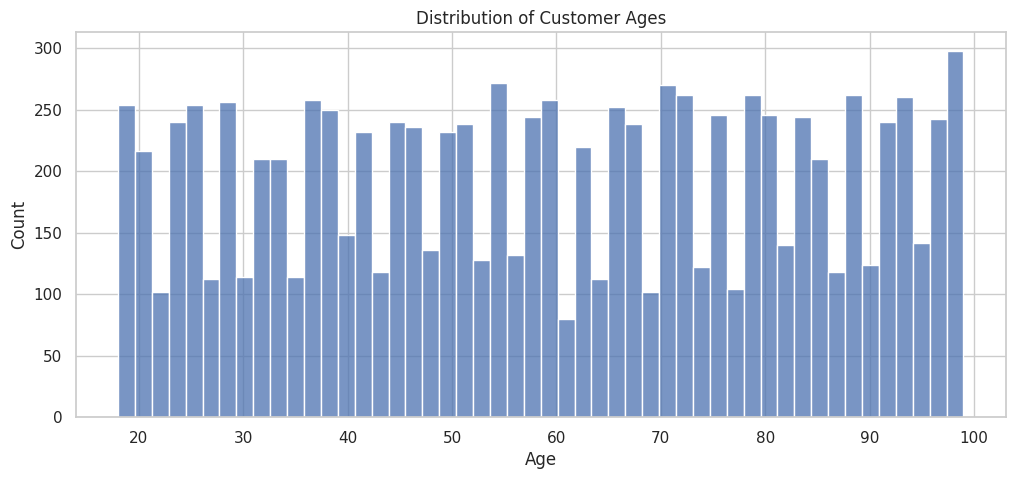

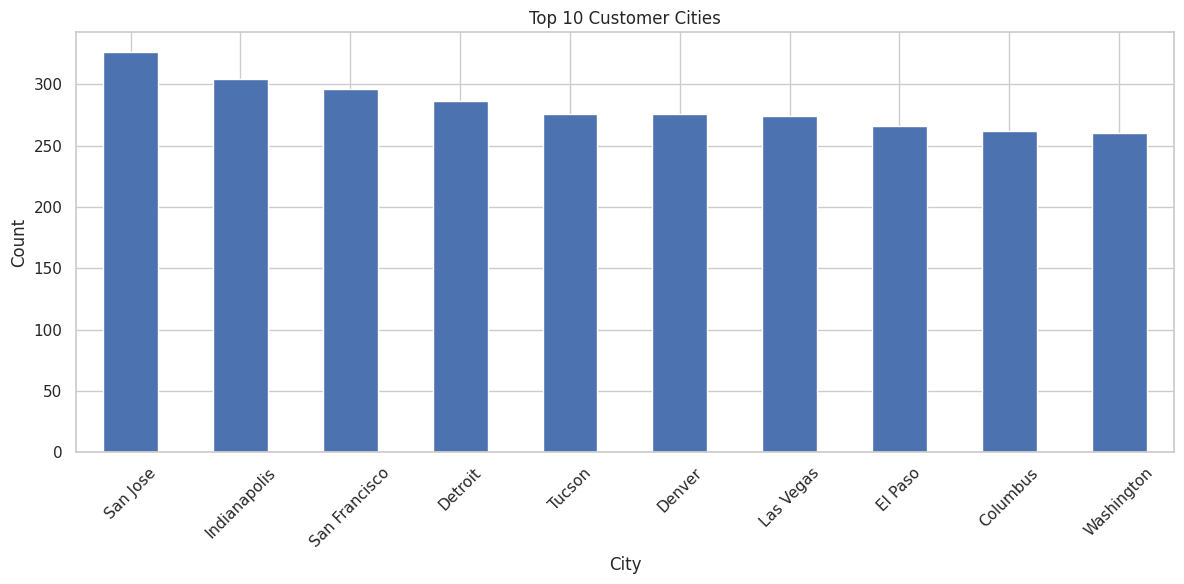

In [68]:
# Investigate customers table
customers_df = execute_query("SELECT * FROM raw.customers")
print(customers_df.columns)

show_samples_with_cleaning(customers_df, n_samples=5)
cleaned_customers_df = clean_dataframe(customers_df)

# Check for null values
print("Null values in customers table:")
display(cleaned_customers_df.isnull().sum())

# Check for duplicate customer_id
duplicate_customers = cleaned_customers_df.duplicated(subset=['customer_id']).sum()
print(f"Duplicate customer_id: {duplicate_customers}")

# Check distribution of customer ages
plt.figure(figsize=(12, 5))
sns.histplot(cleaned_customers_df['Age'], bins=50)
plt.title('Distribution of Customer Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Check city distribution
plt.figure(figsize=(12, 6))
city_counts = cleaned_customers_df['City'].value_counts().head(10)
city_counts.plot(kind='bar')
plt.title('Top 10 Customer Cities')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
show_samples_with_cleaning(customers_df)


DataFrame shape: (10000, 11)
Data types:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1253
  2. Original: 4685
  3. Original: 1732
  4. Original: 4743
  5. Original: 4522

firstname (object):
  1. Original: Sandra
  2. Original: Jennifer
  3. Original: Paul
  4. Original: Andrew
  5. Original: Donald

lastname (object):
  1. Original: Kersten
  2. Original: Wahl
  3. Original: Mahler
  4. Original: Brüggemann
  5. Original: Adam

Age (int32):
  1. Original: 53
  2. Original: 49
  3. Original: 78
  4. Original: 39
  5. Original: 42

Gender (object):
  1. Original: Male
  2. Original: Female
  3. Original: Other

In [66]:
import re
import pandas as pd
import idna
import unicodedata

def validate_email(email):
    """
    Validates if a string is a properly formatted email address.
    
    Parameters:
    -----------
    email : str
        The email address to validate
        
    Returns:
    --------
    tuple
        (is_valid, error_message)
        is_valid: True if the email is valid, False otherwise
        error_message: Description of the validation error, or None if valid
    """
    if pd.isna(email) or not isinstance(email, str):
        return False, "Email is not a string or is null"
    
    email = email.strip()
    
    # Check for empty string
    if not email:
        return False, "Email is empty"
    
    # Check length constraints
    if len(email) > 254:  # Maximum allowed length for an email address
        return False, "Email is too long (>254 characters)"
    
    # Basic structure check with regex
    # This pattern checks for the basic structure: something@something.something
    basic_pattern = r'^[^@\s]+@[^@\s]+\.[^@\s]+$'
    if not re.match(basic_pattern, email):
        return False, "Email doesn't match basic pattern (user@domain.tld)"
    
    # Split into local and domain parts
    try:
        local, domain = email.rsplit('@', 1)
    except ValueError:
        return False, "Email doesn't contain @ symbol"
    
    # Check local part (before @)
    if not local:
        return False, "Username part before @ is empty"
    
    if len(local) > 64:  # Maximum allowed length for local part
        return False, "Username part is too long (>64 characters)"
    
    # Check for invalid characters in local part
    # Local part can contain a lot of special characters, but some are not allowed outside of quotes
    if not re.match(r'^[a-zA-Z0-9!#$%&\'*+\-/=?^_`{|}~.]+$', local):
        # Check if it's a quoted string, which allows more characters
        if not (local.startswith('"') and local.endswith('"')):
            return False, "Username contains invalid characters"
    
    # Check for consecutive dots in local part
    if '..' in local:
        return False, "Username contains consecutive dots"
    
    # Check domain part (after @)
    if not domain:
        return False, "Domain part after @ is empty"
    
    # Check domain length
    if len(domain) > 253:  # Maximum allowed length for domain
        return False, "Domain is too long (>253 characters)"
    
    # Check domain format - must be something.something
    if not re.match(r'^[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', domain):
        return False, "Domain format is invalid"
    
    # Check for consecutive dots in domain
    if '..' in domain:
        return False, "Domain contains consecutive dots"
    
    # Check for hyphens at the beginning or end of domain parts
    domain_parts = domain.split('.')
    for part in domain_parts:
        if part.startswith('-') or part.endswith('-'):
            return False, "Domain part starts or ends with hyphen"
    
    # Check for IDN (Internationalized Domain Names) - domains with non-ASCII characters
    if not all(ord(c) < 128 for c in domain):
        try:
            # Try to encode as IDNA
            domain.encode('idna')
        except UnicodeError:
            return False, "Domain contains invalid Unicode characters"
    
    # Check TLD (Top-Level Domain)
    tld = domain_parts[-1]
    if len(tld) < 2:
        return False, "Top-level domain is too short"
    
    if not tld.isalpha():
        return False, "Top-level domain should only contain letters"
    
    # All checks passed
    return True, None


def analyze_emails(df, email_column):
    """
    Analyzes email addresses in a DataFrame column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the email column
    email_column : str
        Name of the column containing email addresses
        
    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    if email_column not in df.columns:
        return {"error": f"Column '{email_column}' not found in DataFrame"}
    
    emails = df[email_column]
    total_emails = len(emails)
    null_emails = emails.isna().sum()
    
    results = {
        "total_emails": total_emails,
        "null_emails": null_emails,
        "valid_emails": 0,
        "invalid_emails": 0,
        "unique_domains": set(),
        "common_domains": {},
        "error_types": {},
        "invalid_examples": []
    }
    
    # Validate each email
    for i, email in enumerate(emails):
        if pd.isna(email):
            continue
            
        is_valid, error = validate_email(email)
        
        if is_valid:
            results["valid_emails"] += 1
            # Extract domain for domain analysis
            domain = email.split('@')[1]
            results["unique_domains"].add(domain)
            
            # Count domain occurrences
            if domain in results["common_domains"]:
                results["common_domains"][domain] += 1
            else:
                results["common_domains"][domain] = 1
        else:
            results["invalid_emails"] += 1
            
            # Track error types
            if error in results["error_types"]:
                results["error_types"][error] += 1
            else:
                results["error_types"][error] = 1
                
            # Store examples of invalid emails (up to 10)
            if len(results["invalid_examples"]) < 10:
                results["invalid_examples"].append({
                    "index": i,
                    "email": email,
                    "error": error
                })
    
    # Calculate percentages
    results["valid_percentage"] = (results["valid_emails"] / (total_emails - null_emails) * 100) if (total_emails - null_emails) > 0 else 0
    
    # Convert unique_domains to count
    results["unique_domain_count"] = len(results["unique_domains"])
    results["unique_domains"] = list(results["unique_domains"])
    
    # Sort common domains by frequency
    results["common_domains"] = dict(sorted(results["common_domains"].items(), key=lambda x: x[1], reverse=True)[:10])
    
    return results


def print_email_analysis(results):
    """
    Prints the email analysis results in a readable format.
    
    Parameters:
    -----------
    results : dict
        Results from analyze_emails function
    """
    if "error" in results:
        print(f"Error: {results['error']}")
        return
    
    print("Email Validation Results")
    print("=======================")
    print(f"Total emails analyzed: {results['total_emails']}")
    print(f"Null/missing emails: {results['null_emails']}")
    print(f"Valid emails: {results['valid_emails']} ({results['valid_percentage']:.2f}%)")
    print(f"Invalid emails: {results['invalid_emails']}")
    print(f"Unique domains found: {results['unique_domain_count']}")
    
    print("\nTop 10 Most Common Domains:")
    for domain, count in results['common_domains'].items():
        print(f"  {domain}: {count} emails")
    
    if results['invalid_emails'] > 0:
        print("\nCommon Error Types:")
        for error, count in results['error_types'].items():
            print(f"  {error}: {count} emails")
        
        print("\nExamples of Invalid Emails:")
        for example in results['invalid_examples']:
            print(f"  Index {example['index']}: {example['email']} - {example['error']}")


# Function to check emails in a DataFrame and add validation column
def validate_emails_in_dataframe(df, email_column, add_validation_column=True):
    """
    Validates all emails in a DataFrame column and optionally adds a validation column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the email column
    email_column : str
        Name of the column containing email addresses
    add_validation_column : bool, default=True
        If True, adds a new column with validation results
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added validation column if requested
    dict
        Analysis results
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Analyze emails
    analysis = analyze_emails(df, email_column)
    
    if add_validation_column:
        # Add validation column
        validation_column = f"{email_column}_is_valid"
        result_df[validation_column] = False
        
        # Validate each email
        for i, email in enumerate(result_df[email_column]):
            if pd.isna(email):
                result_df.loc[i, validation_column] = None
            else:
                is_valid, _ = validate_email(email)
                result_df.loc[i, validation_column] = is_valid
    
    return result_df, analysis


   

In [67]:
cleaned_customers_df = clean_dataframe(customers_df)
# Validate emails
df_validated, analysis = validate_emails_in_dataframe(cleaned_customers_df, 'Email')

# Print analysis results
print_email_analysis(analysis)

# Print DataFrame with validation results
print("\nDataFrame with validation results:")
print(df_validated)


Email Validation Results
Total emails analyzed: 10000
Null/missing emails: 0
Valid emails: 8918 (89.18%)
Invalid emails: 1082
Unique domains found: 7

Top 10 Most Common Domains:
  gmx.net: 1342 emails
  posteo.de: 1326 emails
  aol.com: 1272 emails
  googlemail.com: 1268 emails
  outlook.com: 1262 emails
  web.de: 1228 emails
  yahoo.com: 1220 emails

Common Error Types:
  Username contains invalid characters: 1082 emails

Examples of Invalid Emails:
  Index 8: daniel.weiß@gmx.net - Username contains invalid characters
  Index 21: donna.könig@web.de - Username contains invalid characters
  Index 49: sandra.bär@posteo.de - Username contains invalid characters
  Index 53: timothy.rösler@outlook.com - Username contains invalid characters
  Index 76: susan.heß@googlemail.com - Username contains invalid characters
  Index 81: susan.schütze@outlook.com - Username contains invalid characters
  Index 124: daniel.köhn@posteo.de - Username contains invalid characters
  Index 129: michelle.dörr@

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_dataframe(df, outlier_threshold=1.5):
    """
    Analyzes each column in a pandas DataFrame, detecting outliers and providing summary statistics.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze
    outlier_threshold : float, default=1.5
        The threshold for IQR method (typically 1.5 or 3)
    
    Returns:
    --------
    dict
        A dictionary containing analysis results for each column
    """
    results = {}
    
    # Analyze each column
    for column in df.columns:
        col_data = df[column]
        col_type = col_data.dtype
        
        # Initialize column results
        col_results = {
            'data_type': str(col_type),
            'count': len(col_data),
            'missing': col_data.isna().sum(),
            'missing_percentage': (col_data.isna().sum() / len(col_data)) * 100
        }
        
        # Skip if all values are null
        if col_results['missing'] == col_results['count']:
            col_results['summary'] = "All values are missing"
            results[column] = col_results
            continue
        
        # For numeric columns
        if pd.api.types.is_numeric_dtype(col_type) and not pd.api.types.is_bool_dtype(col_type):
            # Basic statistics
            col_results.update({
                'min': col_data.min(),
                'max': col_data.max(),
                'mean': col_data.mean(),
                'median': col_data.median(),
                'std': col_data.std(),
                'skew': col_data.skew()
            })
            
            # Find outliers using IQR method
            Q1 = col_data.quantile(0.25)
            Q3 = col_data.quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - outlier_threshold * IQR
            upper_bound = Q3 + outlier_threshold * IQR
            
            outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
            
            col_results.update({
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outliers_count': len(outliers),
                'outliers_percentage': (len(outliers) / col_results['count']) * 100,
                'outliers_values': outliers.value_counts().to_dict() if len(outliers) <= 10 else f"{len(outliers)} outliers found"
            })
            
            # Calculate Z-scores
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            z_outliers = col_data[z_scores > 3]
            
            col_results.update({
                'z_score_outliers_count': len(z_outliers),
                'z_score_outliers_percentage': (len(z_outliers) / col_results['count']) * 100
            })
            
        # For categorical/object columns
        elif pd.api.types.is_object_dtype(col_type) or pd.api.types.is_bool_dtype(col_type) or pd.api.types.is_categorical_dtype(col_type):
            value_counts = col_data.value_counts()
            unique_count = len(value_counts)
            
            col_results.update({
                'unique_values': unique_count,
                'unique_percentage': (unique_count / col_results['count']) * 100,
                'most_common': value_counts.index[0] if not value_counts.empty else None,
                'most_common_count': value_counts.iloc[0] if not value_counts.empty else 0,
                'most_common_percentage': (value_counts.iloc[0] / col_results['count']) * 100 if not value_counts.empty else 0
            })
            
            # For categorical columns, consider outliers as categories with very few occurrences
            if unique_count > 1:
                rare_threshold = max(0.01, 1 / unique_count)  # Either 1% or 1/unique_values, whichever is higher
                rare_categories = value_counts[value_counts / len(col_data.dropna()) < rare_threshold]
                
                col_results.update({
                    'rare_categories_count': len(rare_categories),
                    'rare_categories': rare_categories.to_dict() if len(rare_categories) <= 10 else f"{len(rare_categories)} rare categories found"
                })
        
        # For datetime columns
        elif pd.api.types.is_datetime64_dtype(col_type):
            col_results.update({
                'min_date': col_data.min(),
                'max_date': col_data.max(),
                'range_days': (col_data.max() - col_data.min()).days if not pd.isna(col_data.min()) and not pd.isna(col_data.max()) else None
            })
            
            # Check for datetime outliers using modified Z-score on Unix timestamps
            if not col_data.dropna().empty:
                timestamps = col_data.dropna().astype(np.int64) // 10**9  # Convert to Unix timestamps
                median = np.median(timestamps)
                mad = np.median(np.abs(timestamps - median))  # Median Absolute Deviation
                
                # MAD standardization (modified Z-score)
                if mad > 0:
                    modified_z_scores = 0.6745 * (timestamps - median) / mad
                    time_outliers = col_data[np.abs(modified_z_scores) > 3.5]
                    
                    col_results.update({
                        'datetime_outliers_count': len(time_outliers),
                        'datetime_outliers_percentage': (len(time_outliers) / col_results['count']) * 100,
                        'datetime_outliers': time_outliers.tolist() if len(time_outliers) <= 5 else f"{len(time_outliers)} date outliers found"
                    })
        
        results[column] = col_results
    
    return results

def display_outlier_analysis(df, analysis_results=None, plot=True, figsize=(12, 5)):
    """
    Displays the outlier analysis and summary statistics for each column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame being analyzed
    analysis_results : dict, optional
        Results from analyze_dataframe function. If None, it will run the analysis.
    plot : bool, default=True
        Whether to generate visualizations for columns with outliers
    figsize : tuple, default=(12, 5)
        Figure size for plots
    """
    if analysis_results is None:
        analysis_results = analyze_dataframe(df)
    
    print(f"DataFrame Shape: {df.shape}")
    print(f"Total Missing Values: {df.isna().sum().sum()}")
    print("-" * 80)
    
    for column, results in analysis_results.items():
        print(f"\n===== COLUMN: {column} ({results['data_type']}) =====")
        print(f"Count: {results['count']}, Missing: {results['missing']} ({results['missing_percentage']:.2f}%)")
        
        # If all values are missing, skip to next column
        if 'summary' in results and results['summary'] == "All values are missing":
            print("All values are missing")
            continue
        
        # For numeric columns
        if pd.api.types.is_numeric_dtype(df[column].dtype) and not pd.api.types.is_bool_dtype(df[column].dtype):
            print(f"Min: {results['min']}, Max: {results['max']}")
            print(f"Mean: {results['mean']:.2f}, Median: {results['median']:.2f}, Std: {results['std']:.2f}")
            print(f"Skewness: {results['skew']:.2f}")
            print(f"Outliers (IQR method): {results['outliers_count']} ({results['outliers_percentage']:.2f}%)")
            print(f"Outliers (Z-score method): {results['z_score_outliers_count']} ({results['z_score_outliers_percentage']:.2f}%)")
            
            if results['outliers_count'] > 0:
                if isinstance(results['outliers_values'], dict):
                    print("Outlier values:")
                    for val, count in results['outliers_values'].items():
                        print(f"  - {val}: {count} occurrences")
                else:
                    print(results['outliers_values'])
            
            if plot and results['outliers_count'] > 0:
                plt.figure(figsize=figsize)
                
                # Box plot
                plt.subplot(1, 2, 1)
                sns.boxplot(x=df[column].dropna())
                plt.title(f'Box Plot: {column}')
                plt.tight_layout()
                
                # Histogram with KDE
                plt.subplot(1, 2, 2)
                sns.histplot(df[column].dropna(), kde=True)
                
                # Add vertical lines for outlier boundaries
                plt.axvline(x=results['lower_bound'], color='r', linestyle='--', alpha=0.7)
                plt.axvline(x=results['upper_bound'], color='r', linestyle='--', alpha=0.7)
                
                plt.title(f'Distribution: {column}')
                plt.tight_layout()
                plt.show()
        
        # For categorical columns
        elif pd.api.types.is_object_dtype(df[column].dtype) or pd.api.types.is_bool_dtype(df[column].dtype) or pd.api.types.is_categorical_dtype(df[column].dtype):
            print(f"Unique Values: {results['unique_values']} ({results['unique_percentage']:.2f}% of total)")
            print(f"Most Common: {results['most_common']} ({results['most_common_count']} occurrences, {results['most_common_percentage']:.2f}%)")
            
            if 'rare_categories_count' in results and results['rare_categories_count'] > 0:
                print(f"Rare Categories: {results['rare_categories_count']}")
                if isinstance(results['rare_categories'], dict):
                    print("Rare category values:")
                    for val, count in results['rare_categories'].items():
                        print(f"  - {val}: {count} occurrences")
                else:
                    print(results['rare_categories'])
            
            if plot and results['unique_values'] <= 30:  # Only plot if not too many categories
                plt.figure(figsize=figsize)
                value_counts = df[column].value_counts().sort_values(ascending=False)
                
                if len(value_counts) > 15:  # If too many categories, show only top ones
                    value_counts = value_counts.head(15)
                    plt.title(f'Top 15 Categories: {column}')
                else:
                    plt.title(f'Category Distribution: {column}')
                
                sns.barplot(x=value_counts.index, y=value_counts.values)
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()
        
        # For datetime columns
        elif pd.api.types.is_datetime64_dtype(df[column].dtype):
            print(f"Min Date: {results['min_date']}")
            print(f"Max Date: {results['max_date']}")
            print(f"Range: {results['range_days']} days")
            
            if 'datetime_outliers_count' in results and results['datetime_outliers_count'] > 0:
                print(f"Date Outliers: {results['datetime_outliers_count']} ({results['datetime_outliers_percentage']:.2f}%)")
                if isinstance(results['datetime_outliers'], list):
                    print("Outlier dates:")
                    for date in results['datetime_outliers']:
                        print(f"  - {date}")
                else:
                    print(results['datetime_outliers'])
            
            if plot:
                plt.figure(figsize=figsize)
                plt.hist(df[column].dropna(), bins=20)
                plt.title(f'Date Distribution: {column}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
        
        print("-" * 80)


In [70]:
analyze_dataframe(customers_df)


{'customer_id': {'data_type': 'int32',
  'count': 10000,
  'missing': np.int64(0),
  'missing_percentage': np.float64(0.0),
  'min': np.int32(1),
  'max': np.int32(5000),
  'mean': np.float64(2500.5),
  'median': np.float64(2500.5),
  'std': np.float64(1443.4478183018657),
  'skew': np.float64(0.0),
  'Q1': np.float64(1250.75),
  'Q3': np.float64(3750.25),
  'IQR': np.float64(2499.5),
  'lower_bound': np.float64(-2498.5),
  'upper_bound': np.float64(7499.5),
  'outliers_count': 0,
  'outliers_percentage': 0.0,
  'outliers_values': {},
  'z_score_outliers_count': 0,
  'z_score_outliers_percentage': 0.0},
 'firstname': {'data_type': 'object',
  'count': 10000,
  'missing': np.int64(0),
  'missing_percentage': np.float64(0.0),
  'unique_values': 50,
  'unique_percentage': 0.5,
  'most_common': 'Timothy',
  'most_common_count': np.int64(248),
  'most_common_percentage': np.float64(2.48),
  'rare_categories_count': 25,
  'rare_categories': '25 rare categories found'},
 'lastname': {'data_ty

DataFrame Shape: (10000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 10000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.45
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 10000, Missing: 0 (0.00%)
Unique Values: 50 (0.50% of total)
Most Common: Timothy (248 occurrences, 2.48%)
Rare Categories: 25
25 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 10000, Missing: 0 (0.00%)
Unique Values: 996 (9.96% of total)
Most Common: Schütt (26 occurrences, 0.26%)
Rare Categories: 996
996 rare categories found
--------------------------------------------------------------------------------

==

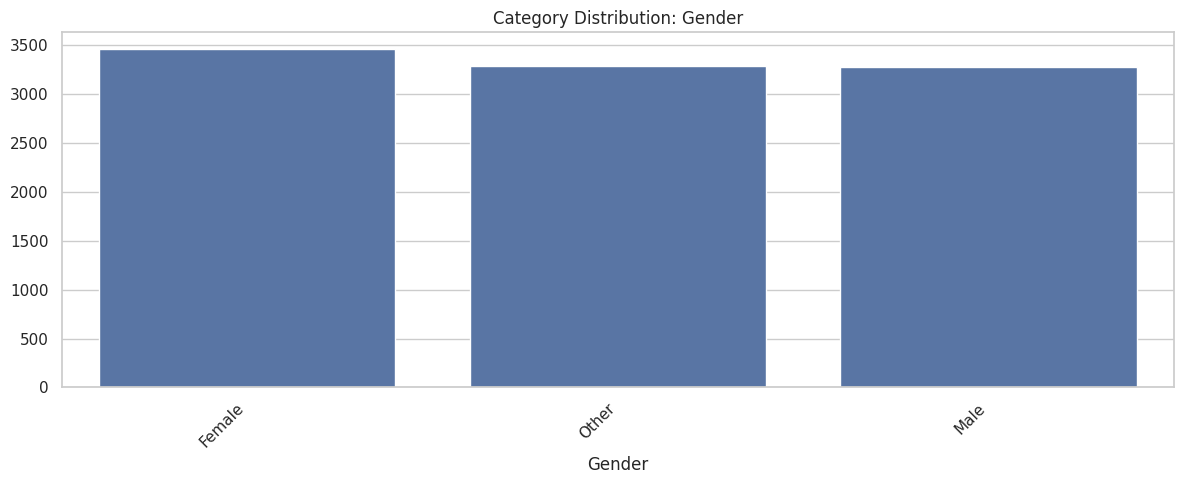

--------------------------------------------------------------------------------

===== COLUMN: Address (object) =====
Count: 10000, Missing: 0 (0.00%)
Unique Values: 5000 (50.00% of total)
Most Common: Address_5000 (2 occurrences, 0.02%)
Rare Categories: 5000
5000 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: City (object) =====
Count: 10000, Missing: 0 (0.00%)
Unique Values: 40 (0.40% of total)
Most Common: San Jose (326 occurrences, 3.26%)
Rare Categories: 20
20 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: Contact Number (int64) =====
Count: 10000, Missing: 0 (0.00%)
Min: 49037065, Max: 490999756607
Mean: 408144494563.85, Median: 490440032285.50, Std: 173659045209.28
Skewness: -1.64
Outliers (IQR method): 1840 (18.40%)
Outliers (Z-score method): 0 (0.00%)
1840 outliers found


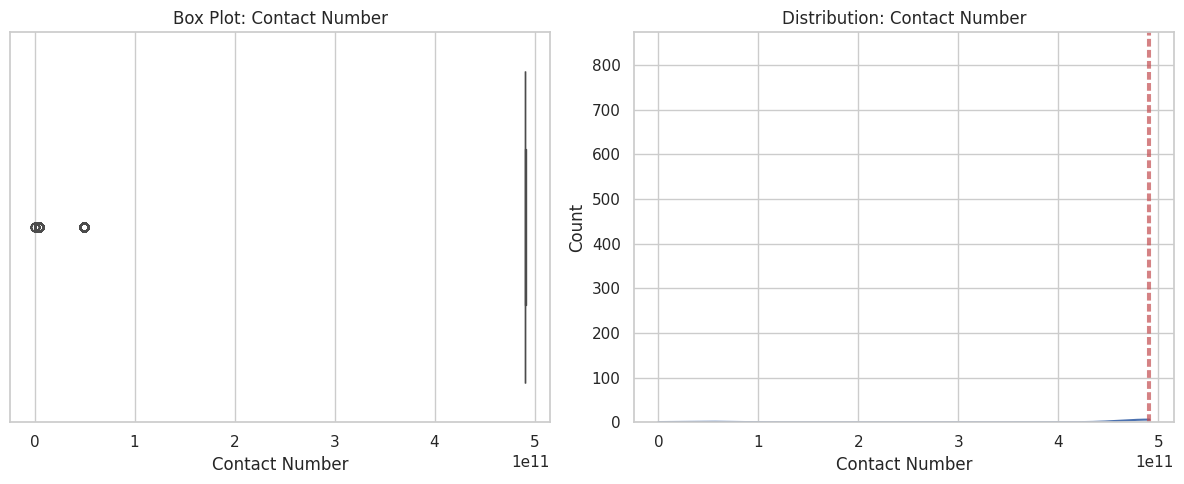

--------------------------------------------------------------------------------

===== COLUMN: Email (object) =====
Count: 10000, Missing: 0 (0.00%)
Unique Values: 4944 (49.44% of total)
Most Common: kenneth.rudolf@gmx.net (4 occurrences, 0.04%)
Rare Categories: 4944
4944 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: creation_date (object) =====
Count: 10000, Missing: 0 (0.00%)
Unique Values: 3924 (39.24% of total)
Most Common: 28.04.2012 (10 occurrences, 0.10%)
Rare Categories: 3924
3924 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: branch_id (int32) =====
Count: 10000, Missing: 0 (0.00%)
Min: 1, Max: 99
Mean: 50.59, Median: 50.00, Std: 28.50
Skewness: -0.01
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------


In [71]:
display_outlier_analysis(customers_df, plot=True)


In [76]:
# count number of digits in column "Contract Number"
def count_digits_in_column(df, column_name):
    """
    Counts the number of digits in each entry of a specified column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the column
    column_name : str
        The name of the column to analyze
        
    Returns:
    --------
    pandas.Series
        A Series with the count of digits for each entry in the specified column
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")
    
    return df[column_name].astype(str).str.count(r'\d')




In [79]:
cleaned_customers_df.columns

Index(['customer_id', 'firstname', 'lastname', 'Age', 'Gender', 'Address',
       'City', 'Contact Number', 'Email', 'creation_date', 'branch_id'],
      dtype='object')

In [78]:
# Example usage
count_digits_in_column(cleaned_customers_df, 'Contact Number').value_counts()

Contact Number
12    8160
11    1578
10     244
9       16
8        2
Name: count, dtype: int64

In [81]:
cleaned_customers_df["customer_id"]


0          1
1          2
2          3
3          4
4          5
        ... 
9995    4996
9996    4997
9997    4998
9998    4999
9999    5000
Name: customer_id, Length: 10000, dtype: int32

In [ ]:
cleaned_customers_df.head()


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
0,1,Joshua,Heck,79,Male,Address_1,Fort Worth,490248463613,joshua.heck@aol.com,2017-06-14,43
1,2,Mark,Fleischmann,70,Female,Address_2,Louisville,490374533855,mark.fleischmann@posteo.de,2016-10-28,63
2,3,Joseph,Wilke,88,Female,Address_3,Philadelphia,490320325342,joseph.wilke@posteo.de,2004-09-08,82
3,4,Kevin,Seifert,62,Other,Address_4,Oklahoma City,490229477177,kevin.seifert@web.de,1995-10-27,41
4,5,Linda,Mann,18,Other,Address_5,Phoenix,490260430689,linda.mann@aol.com,2012-06-14,9


In [80]:
count_digits_in_column(cleaned_customers_df, "customer_id").value_counts()


customer_id
4    8002
3    1800
2     180
1      18
Name: count, dtype: int64

In [95]:
def check_id_duplicates(df, id_columns=None, return_duplicates=True):
    """
    Checks for duplicates in specified ID columns or detects ID columns automatically.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze
    id_columns : list, optional
        List of column names to check for duplicates. If None, will try to auto-detect ID columns.
    return_duplicates : bool, default=True
        Whether to return the duplicate records
    
    Returns:
    --------
    dict
        A dictionary containing duplicate analysis results
    """
    results = {}
    
    # Auto-detect ID columns if not specified
    if id_columns is None:
        # Look for columns with 'id', 'key', 'code', or 'num' in their name (case insensitive)
        possible_id_cols = [col for col in df.columns if any(id_term in col.lower() for id_term in ['id', 'key', 'code', 'num'])]
        
        # Also consider columns that are unique or nearly unique (>95% unique values)
        for col in df.columns:
            if col not in possible_id_cols:
                unique_ratio = df[col].nunique() / len(df)
                if unique_ratio > 0.95 and df[col].nunique() > 1:  # Avoid constant columns
                    possible_id_cols.append(col)
        
        id_columns = possible_id_cols
        results['auto_detected_id_columns'] = id_columns
    
    if not id_columns:
        results['status'] = "No ID columns found or specified"
        return results
    
    # Check each ID column
    for col in id_columns:
        if col not in df.columns:
            results[col] = {"error": f"Column '{col}' not found in DataFrame"}
            continue
        
        # Check for missing values
        missing_count = df[col].isna().sum()
        missing_percentage = (missing_count / len(df)) * 100
        
        # Check for duplicates
        duplicate_values = df[col].value_counts()
        duplicate_values = duplicate_values[duplicate_values > 1]
        duplicate_count = len(duplicate_values)
        duplicate_records = df[df[col].isin(duplicate_values.index)].sort_values(by=col)
        
        col_results = {
            'missing_count': missing_count,
            'missing_percentage': missing_percentage,
            'has_duplicates': duplicate_count > 0,
            'duplicate_values_count': duplicate_count,
            'records_with_duplicates': len(duplicate_records),
            'duplicate_values': duplicate_values.to_dict() 
        }
        
        # For small duplicate sets, include the actual records
        if return_duplicates and duplicate_count > 0:
            if len(duplicate_records) <= 100:  # Only return if not too many
                col_results['duplicate_records'] = duplicate_records
            else:
                col_results['duplicate_records_notice'] = f"Too many duplicate records ({len(duplicate_records)}) to display"
        
        results[col] = col_results
    
    # Check for composite keys
    if len(id_columns) > 1:
        # Check if multiple columns together form a unique key
        composite_key_dupes = df.duplicated(subset=id_columns, keep=False)
        composite_dupes_count = composite_key_dupes.sum()
        
        results['composite_key'] = {
            'columns': id_columns,
            'has_duplicates': composite_dupes_count > 0,
            'duplicate_records_count': composite_dupes_count
        }
        
        if composite_dupes_count > 0 and return_duplicates:
            composite_dupe_records = df[composite_key_dupes].sort_values(by=id_columns)
            if len(composite_dupe_records) <= 100:
                results['composite_key']['duplicate_records'] = composite_dupe_records
            else:
                results['composite_key']['duplicate_records_notice'] = f"Too many duplicate records ({composite_dupes_count}) to display"
    
    return results

def display_duplicate_analysis(df, id_columns=None, analysis_results=None):
    """
    Displays the results of duplicate analysis in a readable format.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame being analyzed
    id_columns : list, optional
        List of column names to check for duplicates
    analysis_results : dict, optional
        Results from check_id_duplicates function. If None, it will run the analysis.
    """
    if analysis_results is None:
        analysis_results = check_id_duplicates(df, id_columns)
    
    print(f"DataFrame Shape: {df.shape}")
    print("-" * 80)
    
    if 'status' in analysis_results and analysis_results['status'] == "No ID columns found or specified":
        print("No ID columns found or specified")
        return
    
    if 'auto_detected_id_columns' in analysis_results:
        print(f"Auto-detected ID columns: {', '.join(analysis_results['auto_detected_id_columns'])}")
        print("-" * 80)
    
    # Skip metadata keys when iterating through column results
    skip_keys = ['status', 'auto_detected_id_columns', 'composite_key']
    
    for col, results in analysis_results.items():
        if col in skip_keys:
            continue
            
        if 'error' in results:
            print(f"\n===== COLUMN: {col} =====")
            print(results['error'])
            continue
            
        print(f"\n===== COLUMN: {col} =====")
        print(f"Missing values: {results['missing_count']} ({results['missing_percentage']:.2f}%)")
        
        if results['has_duplicates']:
            print(f"DUPLICATES FOUND: {results['duplicate_values_count']} distinct values are duplicated")
            print(f"Total records with duplicate values: {results['records_with_duplicates']}")
            
            # Print the duplicate values and their counts
            if isinstance(results['duplicate_values'], dict):
                print("\nDuplicate values (value: count):")
                for val, count in results['duplicate_values'].items():
                    print(f"  - {val}: {count} occurrences")
            else:
                print(f"\n{results['duplicate_values']}")
            
            # Print the actual records if available
            if 'duplicate_records' in results:
                print("\nDuplicate records:")
                print(results['duplicate_records'])
            elif 'duplicate_records_notice' in results:
                print(f"\n{results['duplicate_records_notice']}")
        else:
            print("No duplicates found. This column contains unique values.")
        
        print("-" * 80)
    
    # Check composite key results
    if 'composite_key' in analysis_results:
        composite_results = analysis_results['composite_key']
        print("\n===== COMPOSITE KEY ANALYSIS =====")
        print(f"Columns analyzed as composite key: {', '.join(composite_results['columns'])}")
        
        if composite_results['has_duplicates']:
            print(f"DUPLICATES FOUND: {composite_results['duplicate_records_count']} records have duplicate composite key values")
            
            if 'duplicate_records' in composite_results:
                print("\nRecords with duplicate composite keys:")
                print(composite_results['duplicate_records'])
            elif 'duplicate_records_notice' in composite_results:
                print(f"\n{composite_results['duplicate_records_notice']}")
        else:
            print("No duplicates found. These columns together form a unique composite key.")
        
        print("-" * 80)

# Example usage:
# duplicate_results = check_id_duplicates(df, ['customer_id', 'branch_id'])
# display_duplicate_analysis(df, analysis_results=duplicate_results)


In [97]:
display_duplicate_analysis(cleaned_customers_df, id_columns=['customer_id', 'branch_id'])

DataFrame Shape: (10000, 11)
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
DUPLICATES FOUND: 5000 distinct values are duplicated
Total records with duplicate values: 10000

Duplicate values (value: count):
  - 5000: 2 occurrences
  - 1: 2 occurrences
  - 2: 2 occurrences
  - 3: 2 occurrences
  - 4: 2 occurrences
  - 5: 2 occurrences
  - 6: 2 occurrences
  - 7: 2 occurrences
  - 4984: 2 occurrences
  - 4983: 2 occurrences
  - 4982: 2 occurrences
  - 4981: 2 occurrences
  - 4980: 2 occurrences
  - 4979: 2 occurrences
  - 4978: 2 occurrences
  - 4977: 2 occurrences
  - 4976: 2 occurrences
  - 4975: 2 occurrences
  - 4974: 2 occurrences
  - 4973: 2 occurrences
  - 4972: 2 occurrences
  - 4971: 2 occurrences
  - 4970: 2 occurrences
  - 4969: 2 occurrences
  - 40: 2 occurrences
  - 39: 2 occurrences
  - 38: 2 occurrences
  - 37: 2 occurrences
  - 36: 2 occurrences
  - 35: 2 occurrences
  - 34: 2 occ

In [ ]:
def check_id_properties(df, id_column):
    """
    Checks properties of a specified ID column in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze
    id_column : str
        The name of the ID column to check
        
    Returns:
    --------
    dict
        A dictionary containing properties of the ID column
    """
    if id_column not in df.columns:
        raise ValueError(f"Column '{id_column}' not found in DataFrame")
    
    results = {}
    
    # Check uniqueness
    results['is_unique'] = df[id_column].is_unique
    
    # Check monotonicity
    results['is_monotonic_inc'] = df[id_column].is_monotonic_increasing
    results['is_monotonic_dec'] = df[id_column].is_monotonic_decreasing
    results['is_monotonic'] = results['is_monotonic_inc'] or results['is_monotonic_dec']
    
    return results

check_id_properties(cleaned_customers_df, 'customer_id')

{'is_unique': False,
 'is_monotonic_inc': False,
 'is_monotonic_dec': False,
 'is_monotonic': False}

In [93]:
res_dupl_analysis = check_id_duplicates(cleaned_customers_df, id_columns=['customer_id', 'branch_id'], return_duplicates=True)

res_dupl_analysis.keys()


dict_keys(['customer_id', 'branch_id', 'composite_key'])

In [94]:
res_dupl_analysis['customer_id']


{'missing_count': np.int64(0),
 'missing_percentage': np.float64(0.0),
 'has_duplicates': True,
 'duplicate_values_count': 5000,
 'records_with_duplicates': 10000,
 'duplicate_values': '5000 duplicate values found',
 'duplicate_records_notice': 'Too many duplicate records (10000) to display'}

## Examining Accounts Table

Null values in accounts table:


account_id              0
customer_id             0
account_type            0
account_opening_date    0
dtype: int64

Duplicate account_id: 0


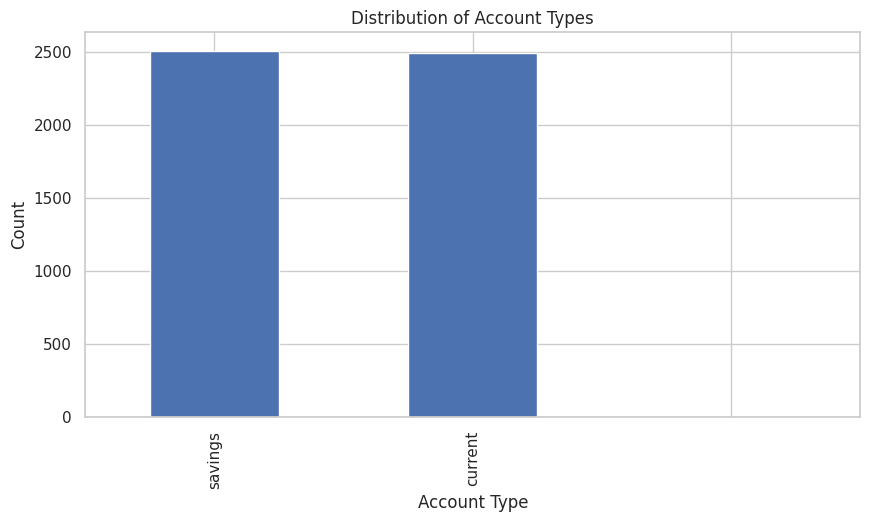

/tmp/ipykernel_3763/657948976.py:21: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  accounts_df['opening_date'] = pd.to_datetime(accounts_df['account_opening_date'], errors='coerce')


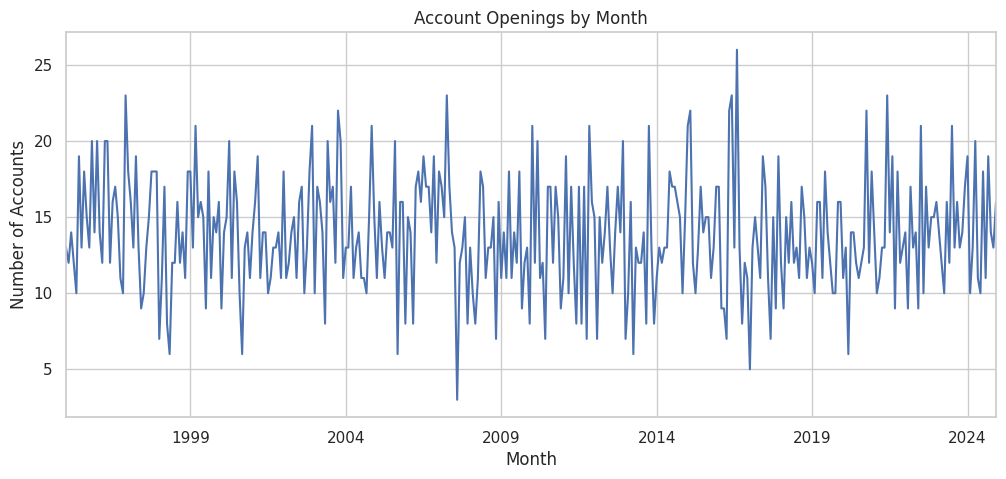

In [17]:
# Investigate accounts table
accounts_df = execute_query("SELECT * FROM raw.accounts")

# Check for null values
print("Null values in accounts table:")
display(accounts_df.isnull().sum())

# Check for duplicate account_id
duplicate_accounts = accounts_df.duplicated(subset=['account_id']).sum()
print(f"Duplicate account_id: {duplicate_accounts}")

# Check account types distribution
plt.figure(figsize=(10, 5))
accounts_df['account_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Account Types')
plt.xlabel('Account Type')
plt.ylabel('Count')
plt.show()

# Check account opening dates
accounts_df['opening_date'] = pd.to_datetime(accounts_df['account_opening_date'], errors='coerce')
accounts_by_month = accounts_df.groupby(accounts_df['opening_date'].dt.to_period('M')).size()

plt.figure(figsize=(12, 5))
accounts_by_month.plot(kind='line')
plt.title('Account Openings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accounts')
plt.grid(True)
plt.show()

## Examining Transactions Table

Null values in transactions sample:


transaction_id          0
transaction_date        0
account_id              0
transaction_type        0
transaction_amount      0
transaction_currency    0
dtype: int64

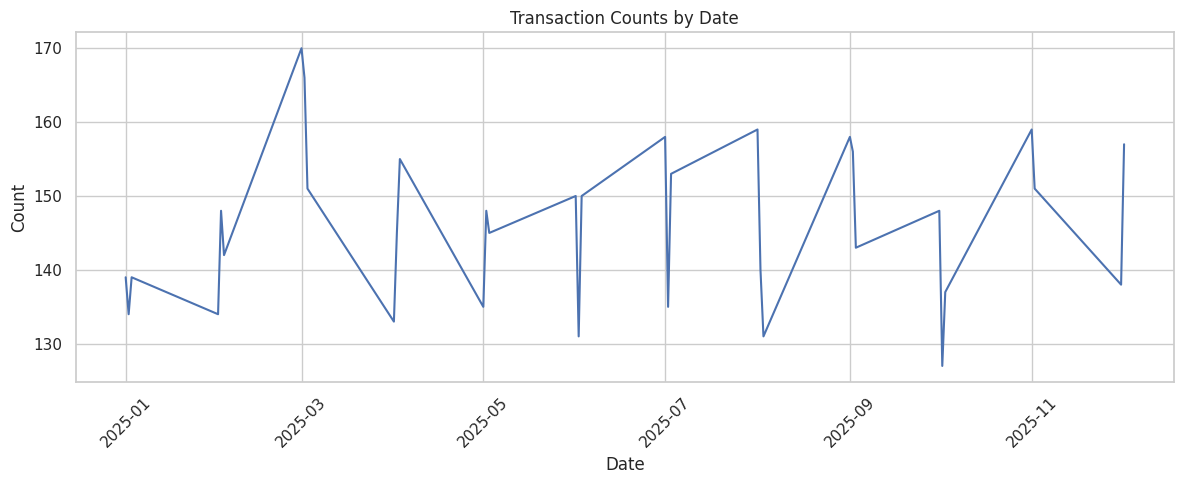

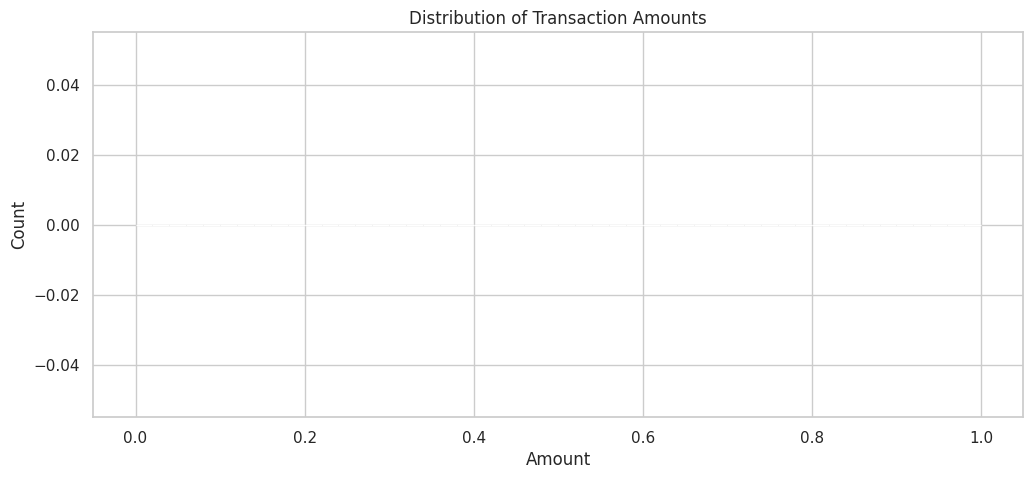

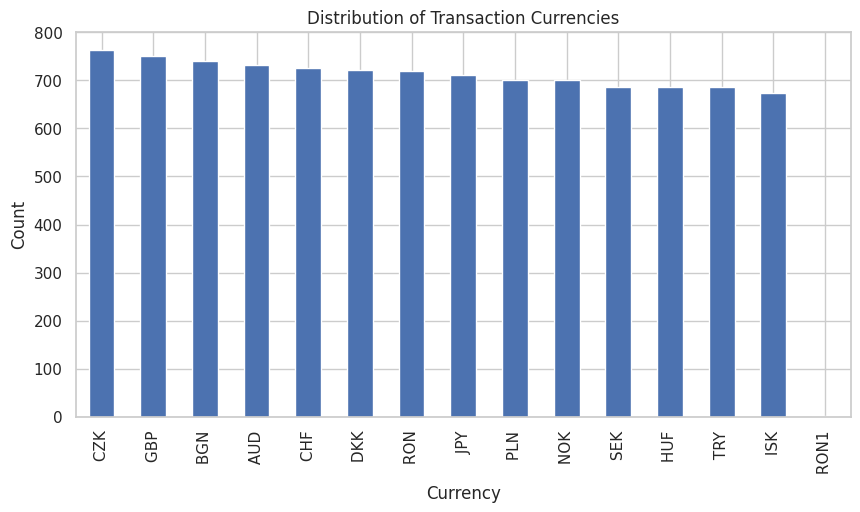

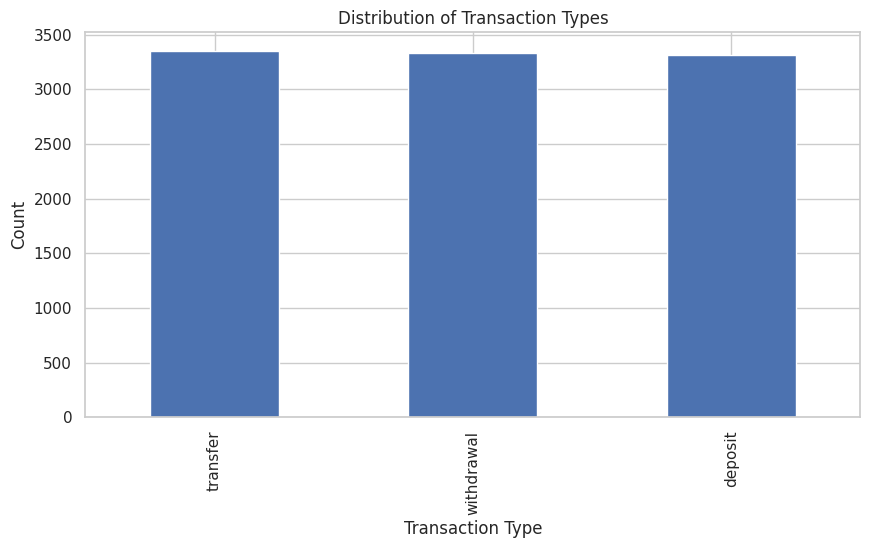

In [59]:

# Investigate transactions table
transactions_df = execute_query("SELECT * FROM raw.transactions LIMIT 10000")

# Check for null values
print("Null values in transactions sample:")
display(transactions_df.isnull().sum())

# Convert transaction_amount to numeric
transactions_df['amount'] = pd.to_numeric(transactions_df['transaction_amount'], errors='coerce')

# Check transaction dates distribution
transactions_df['date'] = pd.to_datetime(transactions_df['transaction_date'], errors='coerce')
plt.figure(figsize=(12, 5))
transactions_df['date'].dt.date.value_counts().sort_index().plot()
plt.title('Transaction Counts by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check amount distribution
plt.figure(figsize=(12, 5))
sns.histplot(transactions_df['amount'], bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

# Check currency distribution
plt.figure(figsize=(10, 5))
transactions_df['transaction_currency'].value_counts().plot(kind='bar')
plt.title('Distribution of Transaction Currencies')
plt.xlabel('Currency')
plt.ylabel('Count')
plt.show()

# Check transaction types
plt.figure(figsize=(10, 5))
transactions_df['transaction_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

## Examining Loans Table

__TODO__: WRONG FMTS: 
1. Amount probably comma sep
2. Interst rate defo comma sep


In [24]:
# Investigate loans table
loans_df = execute_query("SELECT * FROM raw.loans")


loans_df.dtypes

customer_id                 int32
loan_id                     int32
loan_amount                object
loant_type                 object
interest_rate              object
loan_term                   int32
approval_rejection_date    object
loan_status                object
dtype: object

In [25]:
def get_column_samples(df, n_samples=5, dtype_filter=None):
    """
    Returns sample entries for each column in a pandas DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to extract samples from
    n_samples : int, default=5
        Number of sample values to return for each column
    dtype_filter : str or list, default=None
        Filter columns by data type(s). Can be a string or list of strings.
        Common values: 'object', 'int64', 'float64', 'bool', 'datetime64'
        If None, samples from all columns are returned.
    
    Returns:
    --------
    dict
        A dictionary where keys are column names and values are lists of sample values
    """
    samples = {}
    
    # Convert dtype_filter to list if it's a string
    if isinstance(dtype_filter, str):
        dtype_filter = [dtype_filter]
    
    # Get column data types
    dtypes = df.dtypes
    
    # Filter columns by dtype if specified
    if dtype_filter is not None:
        filtered_columns = [col for col in df.columns if dtypes[col].name in dtype_filter]
    else:
        filtered_columns = df.columns
    
    # Get samples for each column
    for col in filtered_columns:
        # Handle empty dataframes
        if len(df) == 0:
            samples[col] = []
            continue
            
        # Get unique values if there are fewer than n_samples unique values
        unique_values = df[col].dropna().unique()
        if len(unique_values) <= n_samples:
            samples[col] = unique_values.tolist()
        else:
            # Try to get a representative sample
            samples[col] = df[col].sample(n_samples, random_state=42).tolist()
    
    return samples


def print_column_samples(df, n_samples=5, dtype_filter=None):
    """
    Prints sample entries for each column in a readable format.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to extract samples from
    n_samples : int, default=5
        Number of sample values to return for each column
    dtype_filter : str or list, default=None
        Filter columns by data type(s)
    """
    samples = get_column_samples(df, n_samples, dtype_filter)
    
    print(f"DataFrame shape: {df.shape}")
    print(f"Data types:\n{df.dtypes}\n")
    print("Sample values by column:")
    print("------------------------")
    
    for col, values in samples.items():
        dtype = df[col].dtype
        print(f"{col} ({dtype}):")
        for i, val in enumerate(values, 1):
            print(f"  {i}. {val}")
        print()



In [ ]:
print_column_samples(loans_df, n_samples=5, dtype_filter=['object', 'int64', 'float64', 'bool', 'datetime64'])

DataFrame shape: (5000, 8)
Data types:
customer_id                 int32
loan_id                     int32
loan_amount                object
loant_type                 object
interest_rate              object
loan_term                   int32
approval_rejection_date    object
loan_status                object
dtype: object

Sample values by column:
------------------------
loan_amount (object):
  1. 29149,52
  2. 48965,54
  3. 12395,31
  4. 39389,58
  5. 37624,25

loant_type (object):
  1. mortgage
  2. auto
  3. personal

interest_rate (object):
  1. 0,0176
  2. 0,0490
  3. 0,0114
  4. 0,0341
  5. 0,0032

approval_rejection_date (object):
  1. 10.08.2020
  2. 07.02.2022
  3. 08.02.2021
  4. 11/19/2020
  5. 02.09.2021

loan_status (object):
  1. rejected
  2. approved
  3. closed



In [63]:
show_samples_with_cleaning(loans_df)


DataFrame shape: (5000, 8)
Data types:
customer_id                 int32
loan_id                     int32
loan_amount                object
loant_type                 object
interest_rate              object
loan_term                   int32
approval_rejection_date    object
loan_status                object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654
  4. Original: 1056
  5. Original: 706

loan_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654
  4. Original: 1056
  5. Original: 706

loan_amount (object):
  1. Original: 29149,52
     Cleaned numeric: 29149.52
  2. Original: 48965,54
     Cleaned numeric: 48965.54
  3. Original: 12395,31
     Cleaned numeric: 12395.31
  4. Original: 39389,58
     Cleaned numeric: 39389.58
  5. Original: 37624,25
     Cleaned numeric: 37624.25

loant_type (object):
  1. Original: 

In [32]:
# Clean the data
cleaned_loans_df = clean_dataframe(loans_df)


cleaned_loans_df.dtypes


customer_id                         int32
loan_id                             int32
loan_amount                       float64
loant_type                         object
interest_rate                     float64
loan_term                           int32
approval_rejection_date    datetime64[ns]
loan_status                        object
dtype: object



Before cleaning:
   customer_id  loan_id loan_amount loant_type interest_rate  loan_term  \
0            1        1    32200,06   mortgage        0,0119         36   
1            2        2    47743,52       auto        0,0297         36   
2            3        3    47981,31       auto        0,0267         24   
3            4        4      4482,8   personal        0,0019         48   
4            5        5     1092,33   mortgage        0,0115         12   

  approval_rejection_date loan_status  
0              05.11.2021    rejected  
1               7/30/2020    approved  
2               1/17/2021      closed  
3               2/15/2022    approved  
4               7/31/2020    approved  

After cleaning:
   customer_id  loan_id  loan_amount loant_type  interest_rate  loan_term  \
0            1        1     32200.06   mortgage         0.0119         36   
1            2        2     47743.52       auto         0.0297         36   
2            3        3     47981.31      

customer_id                0
loan_id                    0
loan_amount                0
loant_type                 0
interest_rate              0
loan_term                  0
approval_rejection_date    0
loan_status                0
dtype: int64

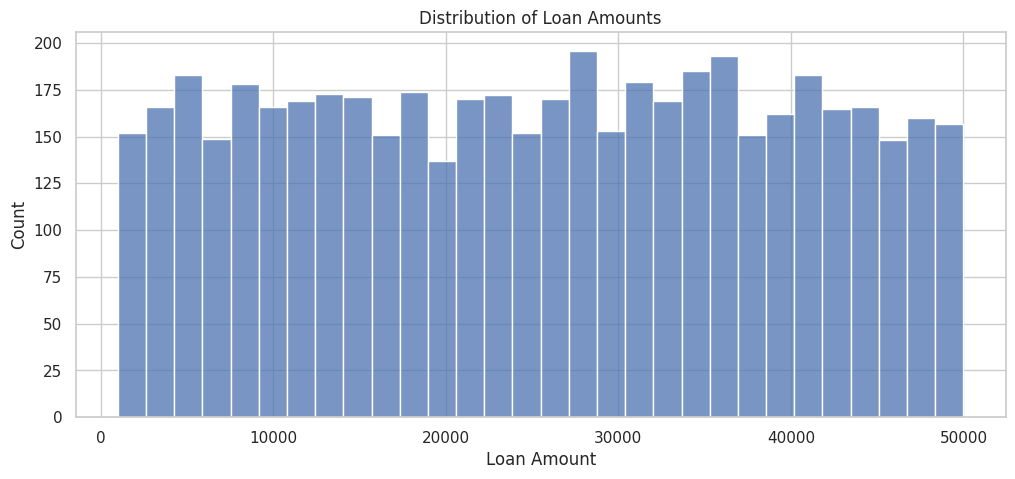

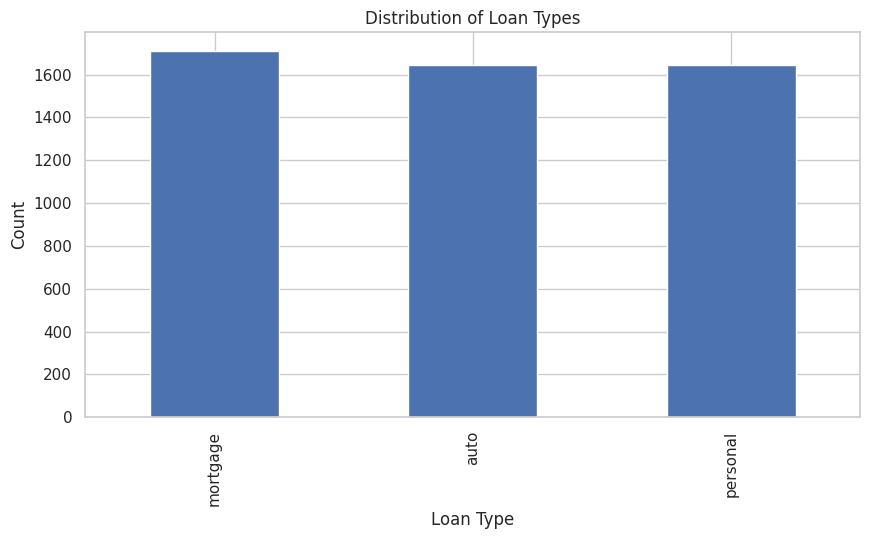

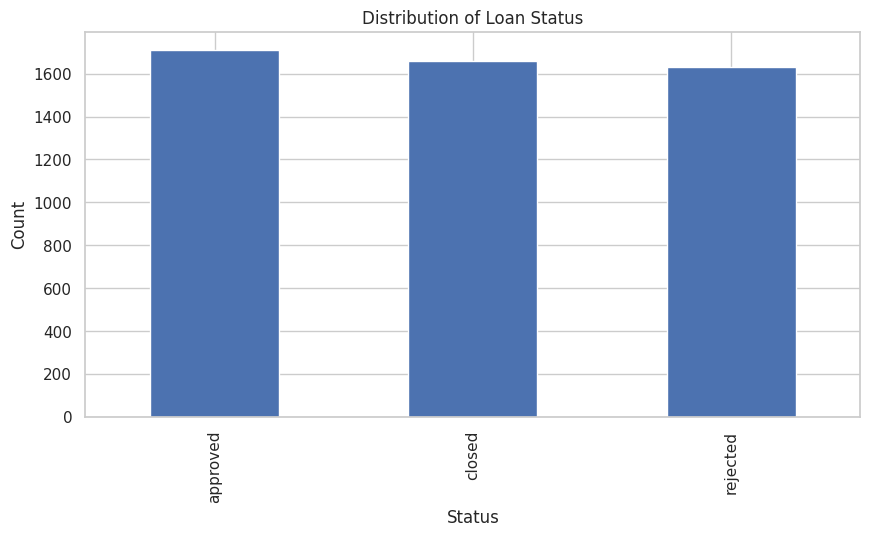

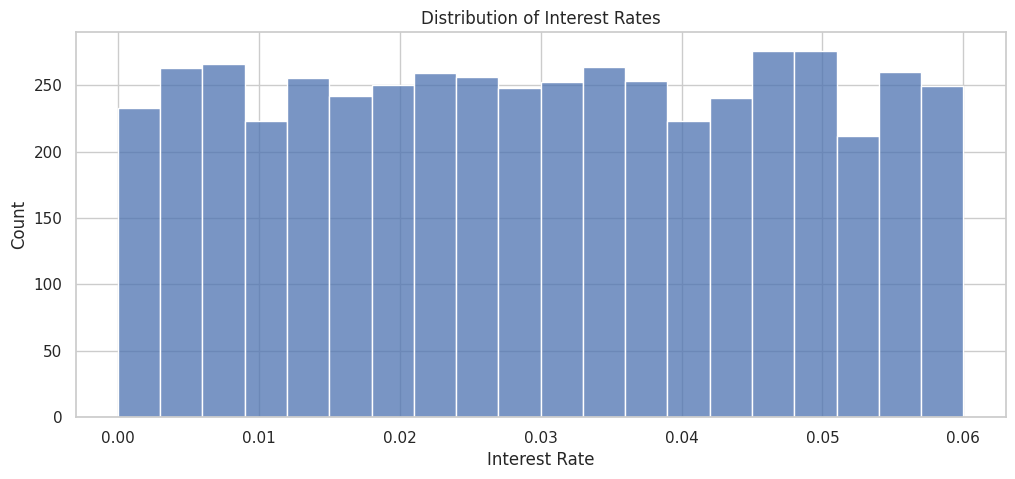

In [35]:

# Show before and after
print("\n\nBefore cleaning:")
print(loans_df.head())

print("\nAfter cleaning:")
print(cleaned_loans_df.head())

# Check for null values
print("Null values in loans table:")
display(cleaned_loans_df.isnull().sum())

# Check loan amounts distribution
plt.figure(figsize=(12, 5))
sns.histplot(cleaned_loans_df['loan_amount'], bins=30)
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.show()

# Check loan types
plt.figure(figsize=(10, 5))
cleaned_loans_df['loant_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Types')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.show()

# Check loan status
plt.figure(figsize=(10, 5))
cleaned_loans_df['loan_status'].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

# Check interest rate distribution
plt.figure(figsize=(12, 5))
sns.histplot(cleaned_loans_df['interest_rate'], bins=20)
plt.title('Distribution of Interest Rates')
plt.xlabel('Interest Rate')
plt.ylabel('Count')
plt.show()

<Axes: ylabel='count'>

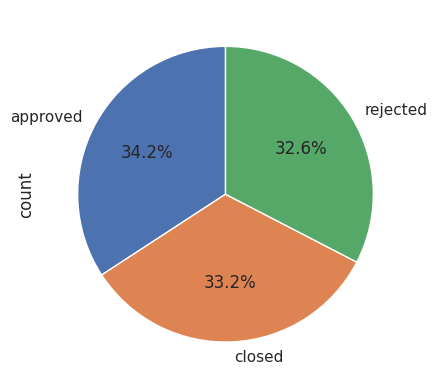

In [39]:
cleaned_loans_df['loan_status'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)


In [43]:
loans_df["approval_rejection_date"].describe()


count          5000
unique         1088
top       8/23/2020
freq             12
Name: approval_rejection_date, dtype: object

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def analyze_datetime_column(df, date_column='approval_rejection_date'):
    """
    Analyze the distribution of dates in a dataframe column that is already in datetime format.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the datetime column
    date_column : str
        Name of the column containing dates (already in datetime format)
    """
    print(f"Analyzing datetime column: {date_column}")
    
    # Verify the column type
    dates = df[date_column]
    
    # Check if it's already a datetime series
    if not pd.api.types.is_datetime64_any_dtype(dates):
        print(f"Warning: Column '{date_column}' is not in datetime format. Current type: {dates.dtype}")
        print("Converting to datetime...")
        try:
            dates = pd.to_datetime(dates)
        except Exception as e:
            print(f"Error converting to datetime: {str(e)}")
            return
    
    # Check for null values
    null_count = dates.isna().sum()
    if null_count > 0:
        print(f"Note: {null_count} values ({null_count/len(dates):.2%}) are null/NaT.")
    
    # Remove null values for analysis
    valid_dates = dates.dropna()
    
    if len(valid_dates) == 0:
        print("No valid dates found for analysis.")
        return
    
    # Check if all dates are in the past
    today = pd.Timestamp.now().normalize()
    future_dates = valid_dates[valid_dates > today]
    
    if len(future_dates) > 0:
        print(f"\nWarning: {len(future_dates)} dates ({len(future_dates)/len(valid_dates):.2%}) are in the future!")
        print("Examples of future dates:")
        for i, (idx, date) in enumerate(future_dates.iloc[:5].items(), 1):
            print(f"  {i}. Row {idx}: {date.strftime('%Y-%m-%d')}")
    else:
        print("\nAll dates are in the past.")
    
    # Calculate summary statistics
    date_min = valid_dates.min()
    date_max = valid_dates.max()
    date_range = (date_max - date_min).days
    
    # Convert to numeric for statistical calculations (days since epoch)
    numeric_dates = valid_dates.astype(np.int64) // 10**9 // 86400
    
    q1 = np.percentile(numeric_dates, 25)
    q3 = np.percentile(numeric_dates, 75)
    iqr = q3 - q1
    
    # Convert back to dates for display
    q1_date = pd.Timestamp(q1 * 86400 * 10**9)
    q3_date = pd.Timestamp(q3 * 86400 * 10**9)
    
    # Calculate mean date
    mean_days = numeric_dates.mean()
    mean_date = pd.Timestamp(mean_days * 86400 * 10**9)
    
    # Calculate median date
    median_days = np.median(numeric_dates)
    median_date = pd.Timestamp(median_days * 86400 * 10**9)
    
    # Calculate standard deviation in days
    std_days = numeric_dates.std()
    
    # Summary table
    print("\nDate Distribution Summary:")
    print("--------------------------")
    print(f"Count:                {len(valid_dates)}")
    print(f"Minimum date:         {date_min.strftime('%Y-%m-%d')}")
    print(f"Maximum date:         {date_max.strftime('%Y-%m-%d')}")
    print(f"Range:                {date_range} days")
    print(f"Mean date:            {mean_date.strftime('%Y-%m-%d')}")
    print(f"Median date:          {median_date.strftime('%Y-%m-%d')}")
    print(f"Standard deviation:   {std_days:.2f} days")
    print(f"1st quartile (Q1):    {q1_date.strftime('%Y-%m-%d')}")
    print(f"3rd quartile (Q3):    {q3_date.strftime('%Y-%m-%d')}")
    print(f"Interquartile range:  {iqr:.2f} days")
    
    # Calculate temporal distribution by year and month
    valid_dates_df = pd.DataFrame({'date': valid_dates})
    valid_dates_df['year'] = valid_dates_df['date'].dt.year
    valid_dates_df['month'] = valid_dates_df['date'].dt.month
    
    # Year distribution
    year_counts = valid_dates_df['year'].value_counts().sort_index()
    print("\nDistribution by Year:")
    for year, count in year_counts.items():
        print(f"  {year}: {count} ({count/len(valid_dates):.2%})")
    
    # Month distribution (across all years)
    month_counts = valid_dates_df['month'].value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    print("\nDistribution by Month (all years):")
    for month, count in month_counts.items():
        print(f"  {month_names[month-1]}: {count} ({count/len(valid_dates):.2%})")
    
    # Create visualizations
    plt.figure(figsize=(14, 10))
    
    # Histogram of dates
    plt.subplot(2, 2, 1)
    plt.hist(valid_dates, bins=min(50, date_range//30 + 1), edgecolor='black')
    plt.title('Histogram of Dates')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    
    # Boxplot of dates
    plt.subplot(2, 2, 2)
    plt.boxplot(numeric_dates)
    plt.title('Boxplot of Dates')
    plt.ylabel('Days since epoch')
    # Add specific date labels
    box_positions = [1]
    plt.xticks([])
    
    # Add label annotations
    plt.annotate(f"Min: {date_min.strftime('%Y-%m-%d')}", xy=(1, numeric_dates.min()), 
                 xytext=(1.1, numeric_dates.min()), fontsize=9)
    plt.annotate(f"Q1: {q1_date.strftime('%Y-%m-%d')}", xy=(1, q1), 
                 xytext=(1.1, q1), fontsize=9)
    plt.annotate(f"Median: {median_date.strftime('%Y-%m-%d')}", xy=(1, median_days), 
                 xytext=(1.1, median_days), fontsize=9)
    plt.annotate(f"Q3: {q3_date.strftime('%Y-%m-%d')}", xy=(1, q3), 
                 xytext=(1.1, q3), fontsize=9)
    plt.annotate(f"Max: {date_max.strftime('%Y-%m-%d')}", xy=(1, numeric_dates.max()), 
                 xytext=(1.1, numeric_dates.max()), fontsize=9)
    
    # Bar chart of years
    plt.subplot(2, 2, 3)
    plt.bar(year_counts.index.astype(str), year_counts.values)
    plt.title('Distribution by Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Bar chart of months
    plt.subplot(2, 2, 4)
    plt.bar(month_names, [month_counts.get(i, 0) for i in range(1, 13)])
    plt.title('Distribution by Month')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return valid_dates


Analyzing datetime column: approval_rejection_date

All dates are in the past.

Date Distribution Summary:
--------------------------
Count:                5000
Minimum date:         2020-01-02
Maximum date:         2022-12-31
Range:                1094 days
Mean date:            2021-07-05
Median date:          2021-07-07
Standard deviation:   313.42 days
1st quartile (Q1):    2020-10-05
3rd quartile (Q3):    2022-04-03
Interquartile range:  545.25 days

Distribution by Year:
  2020: 1626 (32.52%)
  2021: 1675 (33.50%)
  2022: 1699 (33.98%)

Distribution by Month (all years):
  Jan: 436 (8.72%)
  Feb: 392 (7.84%)
  Mar: 413 (8.26%)
  Apr: 398 (7.96%)
  May: 451 (9.02%)
  Jun: 452 (9.04%)
  Jul: 397 (7.94%)
  Aug: 462 (9.24%)
  Sep: 421 (8.42%)
  Oct: 405 (8.10%)
  Nov: 366 (7.32%)
  Dec: 407 (8.14%)


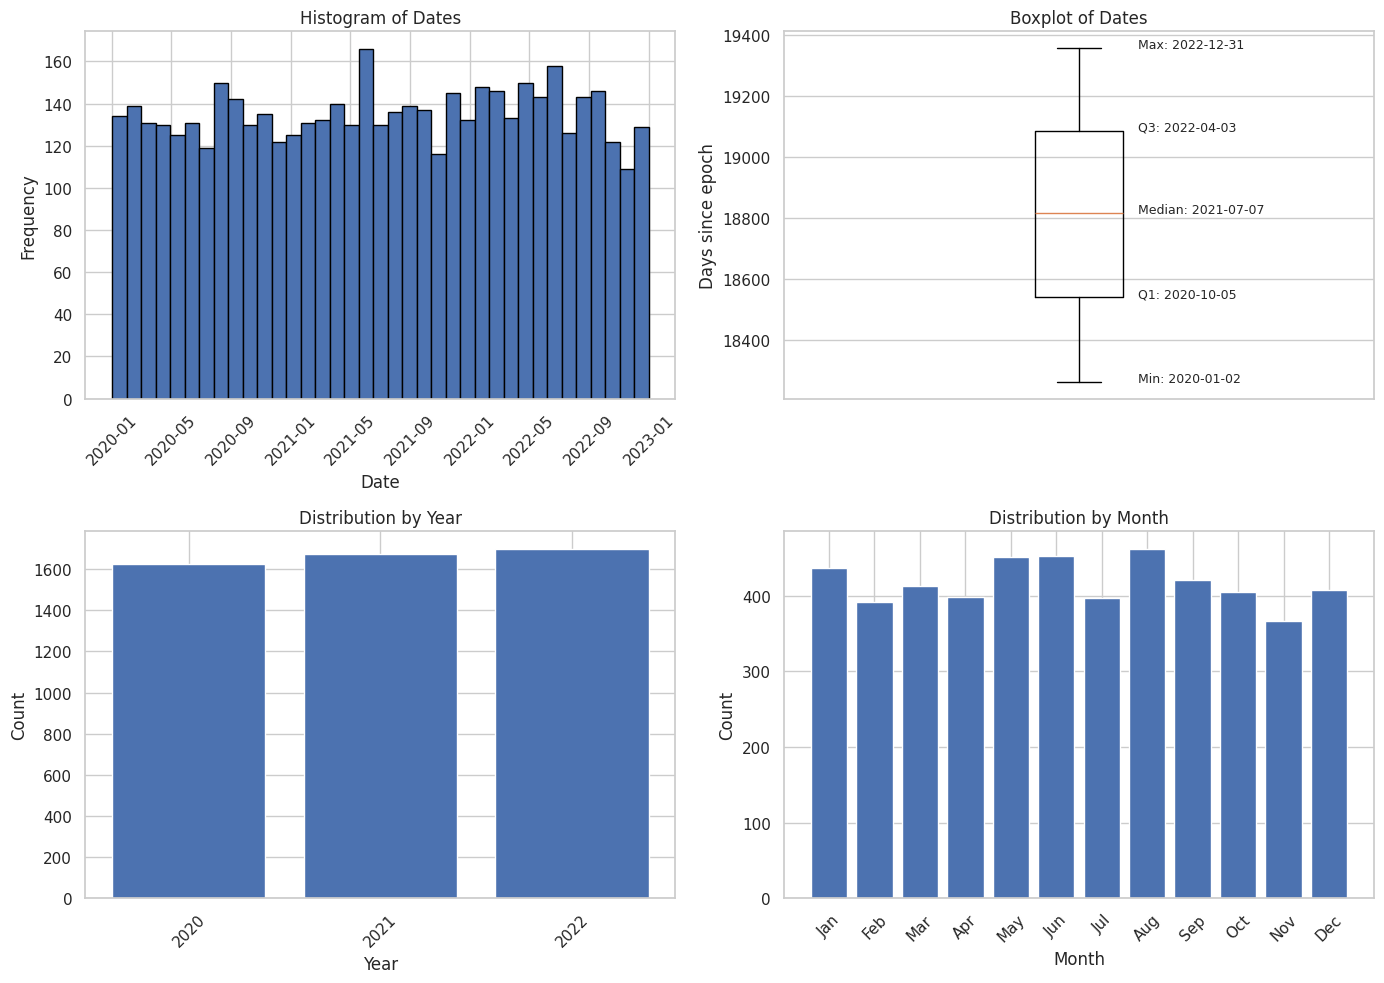

0      2021-11-05
1      2020-07-30
2      2021-01-17
3      2022-02-15
4      2020-07-31
          ...    
4995   2021-10-06
4996   2020-12-24
4997   2020-06-03
4998   2021-08-13
4999   2021-09-23
Name: approval_rejection_date, Length: 5000, dtype: datetime64[ns]

In [48]:
analyze_datetime_column(cleaned_loans_df, date_column='approval_rejection_date')


looks good now



In [ ]:
cleaned_loans_df.columns

Index(['customer_id', 'loan_id', 'loan_amount', 'loant_type', 'interest_rate',
       'loan_term', 'approval_rejection_date', 'loan_status'],
      dtype='object')

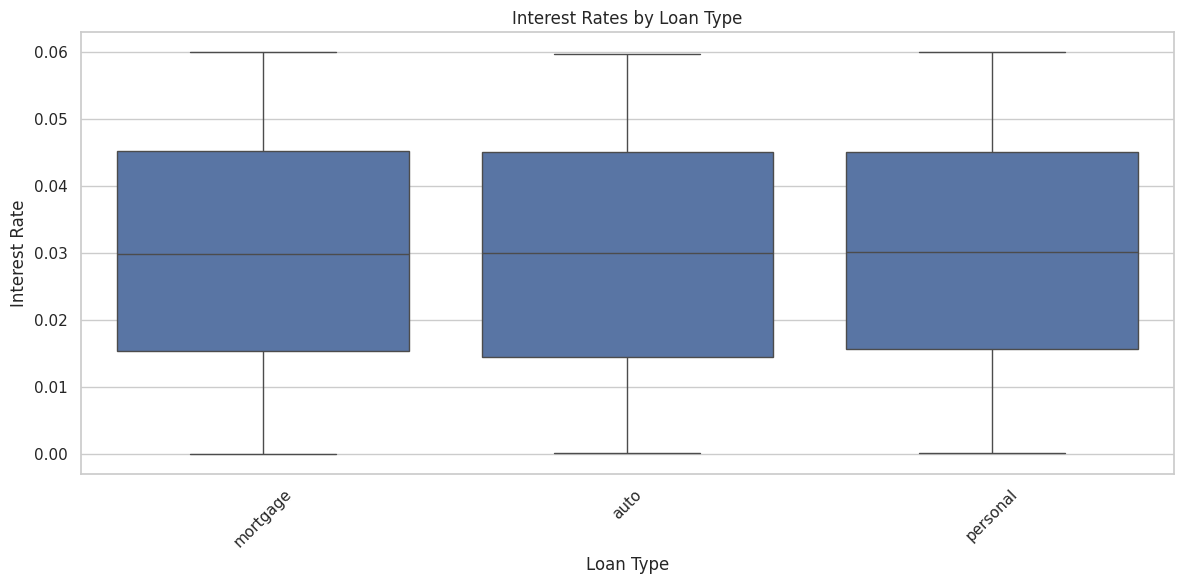

In [51]:
# check distribution of interest rates by loant_type
plt.figure(figsize=(12, 6))
sns.boxplot(x='loant_type', y='interest_rate', data=cleaned_loans_df)
plt.title('Interest Rates by Loan Type')
plt.xlabel('Loan Type')
plt.ylabel('Interest Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


In [54]:
cleaned_loans_df.columns


Index(['customer_id', 'loan_id', 'loan_amount', 'loant_type', 'interest_rate',
       'loan_term', 'approval_rejection_date', 'loan_status'],
      dtype='object')

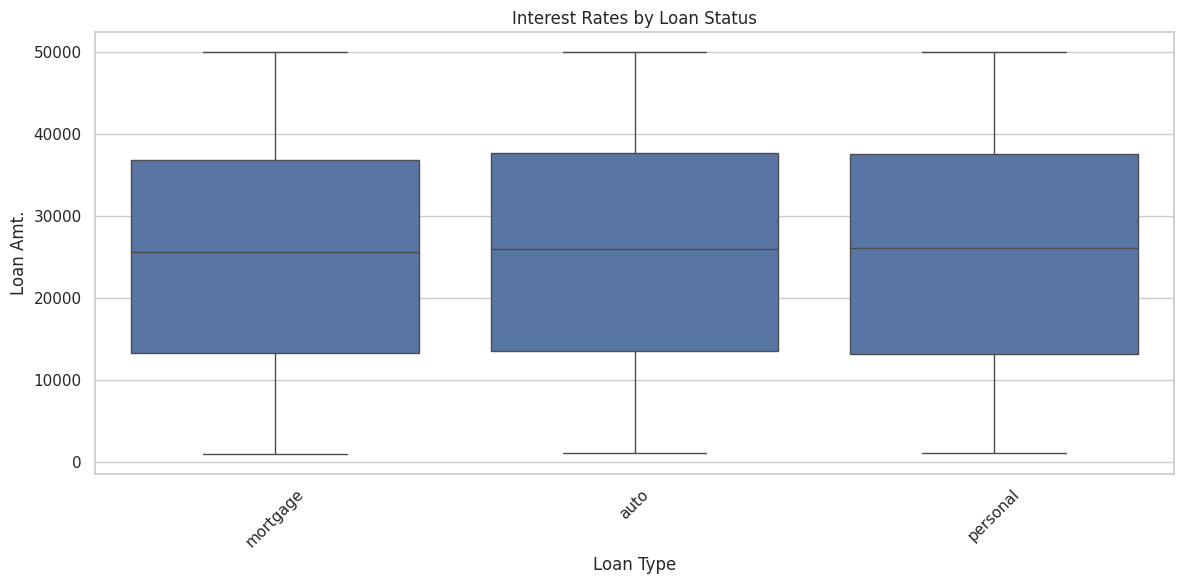

In [56]:
# check distribution of interest rates by loan status
plt.figure(figsize=(12, 6))
sns.boxplot(x='loant_type', y='loan_amount', data=cleaned_loans_df)
plt.title('Interest Rates by Loan Status')
plt.xlabel('Loan Type')
plt.ylabel('Loan Amt.')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Examining FX Rates Table

Null values in fx_rates table:


currency_iso_code    0
fx_rate              0
date                 0
Column4              0
dtype: int64

Currency codes in fx_rates table:


currency_iso_code
USD    1
JPY    1
BGN    1
CZK    1
DKK    1
GBP    1
HUF    1
PLN    1
RON    1
SEK    1
CHF    1
ISK    1
NOK    1
TRY    1
AUD    1
Name: count, dtype: int64

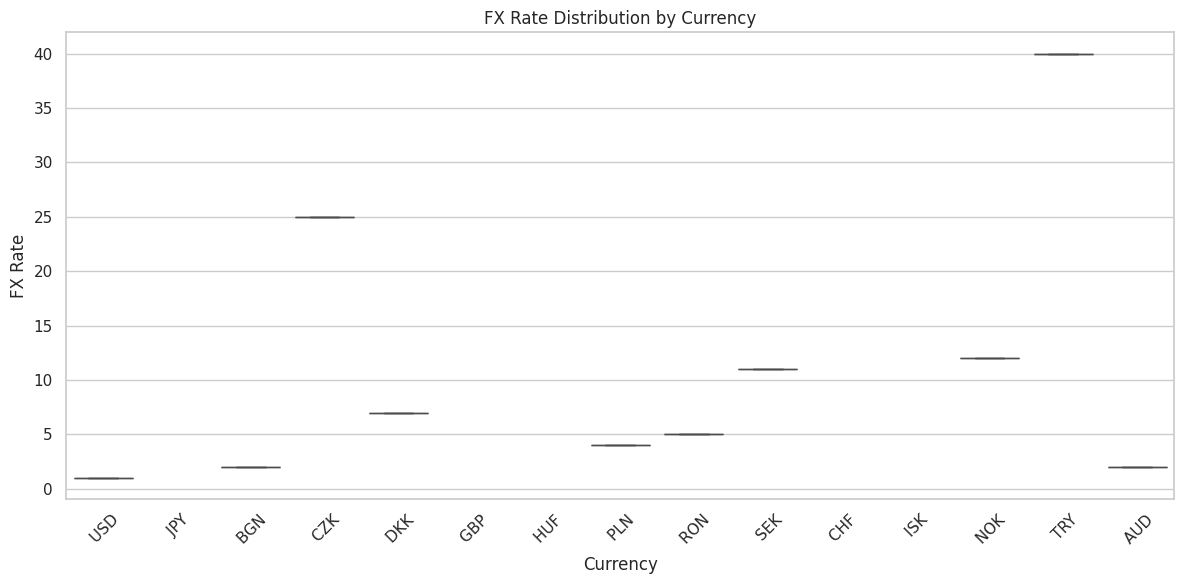

Duplicate currency-date combinations: 0


In [49]:
# Investigate FX rates table
fx_rates_df = execute_query("SELECT * FROM raw.fx_rates")

# Check for null values
print("Null values in fx_rates table:")
display(fx_rates_df.isnull().sum())

# Check currency codes
print("Currency codes in fx_rates table:")
display(fx_rates_df['currency_iso_code'].value_counts())

# Convert fx_rate to numeric
fx_rates_df['rate'] = pd.to_numeric(fx_rates_df['fx_rate'], errors='coerce')

# Check fx rate distribution by currency
plt.figure(figsize=(12, 6))
sns.boxplot(x='currency_iso_code', y='rate', data=fx_rates_df)
plt.title('FX Rate Distribution by Currency')
plt.xlabel('Currency')
plt.ylabel('FX Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check for duplicate dates for same currency
fx_rates_df['date'] = pd.to_datetime(fx_rates_df['date'], errors='coerce')
duplicate_fx = fx_rates_df.duplicated(subset=['currency_iso_code', 'date']).sum()
print(f"Duplicate currency-date combinations: {duplicate_fx}")

## Checking Foreign Key Relationships

In [57]:
# Check if all accounts have valid customer_id references
accounts_invalid_customer = execute_query("""
    SELECT a.account_id, a.customer_id 
    FROM raw.accounts a
    LEFT JOIN raw.customers c ON a.customer_id = c.customer_id
    WHERE c.customer_id IS NULL
""")
print(f"Accounts with invalid customer_id references: {len(accounts_invalid_customer)}")
if len(accounts_invalid_customer) > 0:
    display(accounts_invalid_customer)

# Check if customers have branch_id in the raw schema
customer_branch = execute_query("""
    SELECT COUNT(*) as count
    FROM raw.customers
    WHERE branch_id IS NOT NULL
""")
print(f"Customers with branch_id: {customer_branch['count'][0]}")

# Check if all transactions have valid account_id references
transactions_invalid_account = execute_query("""
    SELECT t.transaction_id, t.account_id 
    FROM raw.transactions t
    LEFT JOIN raw.accounts a ON t.account_id = a.account_id
    WHERE a.account_id IS NULL
    LIMIT 10
""")
print(f"Transactions with invalid account_id references (limit 10): {len(transactions_invalid_account)}")
if len(transactions_invalid_account) > 0:
    display(transactions_invalid_account)

# Check if all loans have valid customer_id references
loans_invalid_customer = execute_query("""
    SELECT l.loan_id, l.customer_id 
    FROM raw.loans l
    LEFT JOIN raw.customers c ON l.customer_id = c.customer_id
    WHERE c.customer_id IS NULL
""")
print(f"Loans with invalid customer_id references: {len(loans_invalid_customer)}")
if len(loans_invalid_customer) > 0:
    display(loans_invalid_customer)

Accounts with invalid customer_id references: 0
Customers with branch_id: 10000
Transactions with invalid account_id references (limit 10): 0
Loans with invalid customer_id references: 0



## Examining FX Rates vs Transaction Currencies

In [ ]:
# Get distinct currencies from transactions
transaction_currencies = execute_query("SELECT DISTINCT transaction_currency FROM raw.transactions")
print("Currencies used in transactions:")
display(transaction_currencies)

# Get distinct currencies from fx_rates
fx_currencies = execute_query("SELECT DISTINCT currency_iso_code FROM raw.fx_rates")
print("Currencies in FX rates table:")
display(fx_currencies)

# Check if all transaction currencies exist in fx_rates
fx_currency_list = fx_currencies['currency_iso_code'].tolist()
missing_currencies = []
for _, row in transaction_currencies.iterrows():
    if row['transaction_currency'] not in fx_currency_list:
        missing_currencies.append(row['transaction_currency'])
print(f"Transaction currencies not in FX rates table: {missing_currencies}")

# Check dates covered in fx_rates
fx_dates = execute_query("""
    SELECT 
        MIN(date::date) as min_date,
        MAX(date::date) as max_date,
        COUNT(DISTINCT date::date) as unique_dates
    FROM raw.fx_rates
""")
print("FX rates date coverage:")
display(fx_dates)

# Check transaction dates
tx_dates = execute_query("""
    SELECT 
        MIN(transaction_date::date) as min_date,
        MAX(transaction_date::date) as max_date,
        COUNT(DISTINCT transaction_date::date) as unique_dates
    FROM raw.transactions
""")
print("Transaction date range:")
display(tx_dates)

Currencies used in transactions:


,transaction_currency
0,CZK
1,HUF
2,SEK
3,AUD
4,GBP
5,BGN
6,RON
7,RON1
8,NOK
9,CHF


Currencies in FX rates table:


,currency_iso_code
0,CZK
1,HUF
2,ISK
3,JPY
4,AUD
5,BGN
6,RON
7,CHF
8,GBP
9,USD


Transaction currencies not in FX rates table: [' RON1']


ConversionException: Conversion Error: invalid date field format: "01.03.2023", expected format is (YYYY-MM-DD)

LINE 3:         MIN(date::date) as min_date,
                        ^

## Examining Currencies CSV File

In [ ]:
# Load currencies CSV file
currencies_df = pd.read_csv('/workspace/data/currencies.csv')
print("Currencies CSV file:")
display(currencies_df)

# Check for missing values
print("Missing values in currencies CSV:")
display(currencies_df.isnull().sum())

# Check for duplicate currency codes
duplicate_currencies = currencies_df.duplicated(subset=['currency_code']).sum()
print(f"Duplicate currency codes: {duplicate_currencies}")

# Check if all transaction currencies exist in the currencies CSV
transaction_currencies = execute_query("SELECT DISTINCT currency FROM raw.transactions")
missing_currencies = []
for _, row in transaction_currencies.iterrows():
    if row['currency'] not in currencies_df['currency_code'].values:
        missing_currencies.append(row['currency'])
print(f"Transaction currencies not in currencies CSV: {missing_currencies}")

## Summary of Data Exploration Findings

Key findings from our data exploration:

1. **Table Structure:**
   - The database follows a normalized structure with customers, accounts, transactions, loans, and branches tables.
   - Primary keys and foreign key relationships are defined according to the ERD.

2. **Data Quality:**
   - [Note any null values, duplicates, or inconsistencies found]
   - [Note any invalid foreign key references]
   - [Note any unusual patterns in dates, amounts, or other fields]

3. **Currencies:**
   - The currencies.csv file contains exchange rates for different currencies against EUR.
   - [Note if all transaction currencies are covered in the CSV]
   - [Note any inconsistencies or issues with the currency data]

4. **Potential Anomalies:**
   - [List specific anomalies found]
   - [Document any data issues that need to be addressed]

5. **Recommendations for Transformation:**
   - [Provide recommendations based on findings]
   - [Suggest data quality checks and tests to implement]